<a href="https://colab.research.google.com/github/illliyas/Machine-Learning/blob/master/poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prediction of German Loan Application

### Importing all necessary libraries

In [ ]:
from scipy.stats import poisson

In [ ]:
# Given parameters
MTBUR = 33850  # Mean Time Between Unscheduled Removals (flight hours per failure)
N = 26       # Fleet size (number of aircraft)
U = 4*4500        # Flight hours per aircraft per day QPA:4 and Annual FH: 4500
REPAIR_LT = 40       # Lead time in days
SL = 0.98    # 98% service level

# Step 1: Calculate failure rate (λ)
λ = (N * U) / MTBUR  # Expected failures per day

# Step 2: Expected demand during lead time
λ_LT = λ * REPAIR_LT  # Expected removals during lead time
λ_LT = λ_LT/365
# Step 3: Find the smallest S where Poisson CDF >= SL
S = 0
while poisson.cdf(S, λ_LT) < SL:
    S += 1

print(f"Recommended inventory float (safety stock) quantity: {S}")

Recommended inventory float (safety stock) quantity: 4


In [ ]:
# Given parameters
MTBUR = 33850  # Mean Time Between Unscheduled Removals (flight hours per failure)
N = 26       # Fleet size (number of aircraft)
U = 4*414781        # Flight hours per aircraft per day QPA:4 and Annual FH: 4500
REPAIR_LT = 40       # Lead time in days
SL = 0.98    # 98% service level

# Step 1: Calculate failure rate (λ)
λ = ( U) / MTBUR  # Expected failures per day

# Step 2: Expected demand during lead time
λ_LT = λ * REPAIR_LT  # Expected removals during lead time
λ_LT = λ_LT/365
# Step 3: Find the smallest S where Poisson CDF >= SL
S = 0
while poisson.cdf(S, λ_LT) < SL:
    S += 1

print(f"Recommended inventory float (safety stock) quantity: {S}")

Recommended inventory float (safety stock) quantity: 11


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pytz
import warnings
import re
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import accuracy_score,auc, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, recall_score, precision_score, f1_score, classification_report, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')
%matplotlib inline

### Reading the data

In [ ]:
df = pd.read_csv('loan_data_track1.csv')

In [ ]:
df.head()

checking_status  duration  ... foreign_worker accepted
0            <0DM         6  ...            yes        2
1      0_to_200DM        48  ...            yes        1
2            None        12  ...            yes        2
3            <0DM        42  ...            yes        2
4            <0DM        24  ...            yes        1

[5 rows x 21 columns]

### Missing Data Check

#### Verify the percentage of null values in each column

In [ ]:
(df.isnull().sum()/len(df))*100

checking_status           0.0
duration                  0.0
loan_history              0.0
purpose                   0.0
loan_amount               0.0
savings_status            0.0
employment                0.0
installment_commitment    0.0
personal_status           0.0
other_parties             0.0
residence_since           0.0
property_magnitude        0.0
age                       0.0
other_payment_plans       0.0
housing                   0.0
existing_loans            0.0
job                       0.0
num_dependents            0.0
own_telephone             0.0
foreign_worker            0.0
accepted                  0.0
dtype: float64

No missing data identified

#### Altering the Accepetd variable to represent 0 as Rejected and 1 as Accepted (But for plot visialization assigned to Rejected and Accepted)

In [ ]:
df['accepted'] = df['accepted'].apply(lambda x: 'Rejected' if x==1 else 'Accepted')

### Data Exploration

In [ ]:
df.head()

checking_status  duration  ... foreign_worker  accepted
0            <0DM         6  ...            yes  Accepted
1      0_to_200DM        48  ...            yes  Rejected
2            None        12  ...            yes  Accepted
3            <0DM        42  ...            yes  Accepted
4            <0DM        24  ...            yes  Rejected

[5 rows x 21 columns]

#### Extracting Gender and marital_status  from personal_status

In [ ]:
df['personal_status'].unique()

array(['male_single', 'female_divorced/separated/married',
       'male_divorced/separated', 'male_married/widowed'], dtype=object)

In [ ]:
df['gender'] = df['personal_status'].apply(lambda x: x.split('_')[0])

In [ ]:
df['gender']

0        male
1      female
2        male
3        male
4        male
        ...  
995    female
996      male
997      male
998      male
999      male
Name: gender, Length: 1000, dtype: object

In [ ]:
df['marital_status'] = df['personal_status'].apply(lambda x: x.split('_')[1])

In [ ]:
df['marital_status']

0                          single
1      divorced/separated/married
2                          single
3                          single
4                          single
                  ...            
995    divorced/separated/married
996            divorced/separated
997                        single
998                        single
999                        single
Name: marital_status, Length: 1000, dtype: object

#### Cleaning  existing_loans lowercase alphabet characters and extracting only numeric

In [ ]:
df['existing_loans'].unique()

array(['m22', 'e1', '1', 'q1', 'p22', 'i1', 'jc22', 'w1', 'r1', '22',
       'g1', 'j22', 'j333', 'a1', 'n1', 'km333', 'dgl22', 'l1', 'c22',
       'h1', 'ks1', 'rv22', 'n22', 'j1', 'ub1', 's22', 'u1', 'do1', 'f1',
       'zn1', 'fo22', 'z1', 'wk1', 'y1', 'fz1', 'ouv22', 's1', 'wt1',
       'bb4444', 'p1', 'nr1', 'o1', 'bp22', 'ebp22', 'b1', 'ha1', 'a22',
       'k1', 'l22', 'qzp1', 'op1', 'v1', 't1', 'xx1', 'zv22', 'rx1',
       'hh22', 'w22', 'x22', 'ziu1', 'tq22', 'c1', 'm1', 't22', 'b22',
       '333', 'cis1', 'z22', 'r22', 'v22', 'ce22', 'e22', 'i22', 'iw1',
       'yl1', 'fd22', 'h22', 'rcl1', 'k22', 'x1', 'yi22', 'd22', 'g22',
       'fe1', 'rr22', 'qd333', 'o333', 'on1', '4444', 'tr22', 'sx1',
       'y22', 'a333', 'hf333', 'nq22', 'xq1', 'nh1', 'ea1', 'yq1', 'fku1',
       'jup22', 'au22', 'shq1', 'wo1', 'ek22', 'ow22', 'to22', 'yb1',
       'ny1', 'sq1', 'qez22', 'd1', 'dd333', 'qm22', 'yh22', 'wa1', 'cn1',
       'oz1', 'kw22', 'ja22', 'qa1', 'vo1', 'q22', 'yv1', 'vu1', 'as1

In [ ]:
df['existing_loans'] = df['existing_loans'].apply(lambda x: re.findall(r'\d+', x)[0][0])

### 3. Univariate Plots & analysis

In [ ]:
sns.set_style("darkgrid")

#### Analysing the Target variable "accepted"

In [ ]:
sns.set()

In [ ]:
accepted_rate = df['accepted'].value_counts(normalize=True)

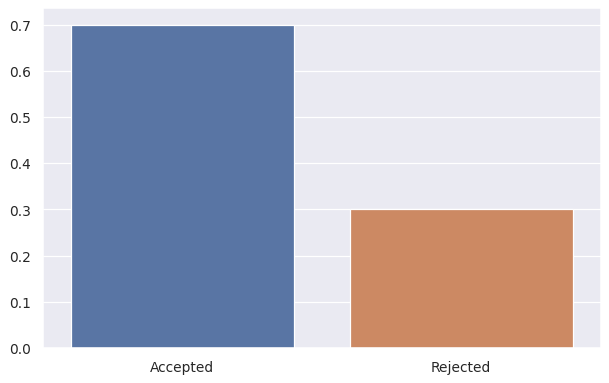

In [ ]:
f, ax = plt.subplots(figsize=(8,5), dpi=90)
sns.barplot(x=accepted_rate.index, y=accepted_rate.values, ax=ax)

70% Loans are accepted and 30% are Rejected. This is a class-imbalance dataset.

### 3.a Univariate Analysis of driving factors/ influencers

In [ ]:
def setLabels(plot, xLabel, yLabel, title):
    plt.ylabel(yLabel, fontsize=18)
    plt.xlabel(xLabel, fontsize=18)
    plt.setp(plot.get_xticklabels(), fontsize=14)
    plt.setp(plot.get_yticklabels(), fontsize=14)
    plot.set_title(title, fontsize=20)

In [ ]:
def createCountPlot(varName, xLabel, yLabel, title):
    count_plot = sns.countplot(varName, hue='accepted',data=df)
    setLabels(count_plot, xLabel, yLabel, title)

In [ ]:
def createPercPlot(varName, xLabel, yLabel, title):
    charge_off_rates = df.groupby(varName)['accepted'].value_counts(normalize=True).loc[:,'Rejected']
    perc_plot = sns.barplot(x=charge_off_rates.reset_index()[varName], y=charge_off_rates.values)
    setLabels(perc_plot, xLabel, yLabel, title)

In [ ]:
def createBarPlot(varName, xLabel, yLabel, title):
    bar_plot = sns.barplot(y=varName, x='accepted',data=loan)
    setLabels(bar_plot, xLabel, yLabel, title)

In [ ]:
def createDistPlot(varName, xLabel, yLabel, title):
    dist_plot = sns.distplot(df[varName])
    setLabels(dist_plot, xLabel, yLabel, title)

def createBoxPlot(varName, xLabel, yLabel, title):
    box_plot = sns.boxplot(x=varName,y='accepted',data=df)
    setLabels(box_plot, xLabel, yLabel, title)

### Continuous variable Analysis

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

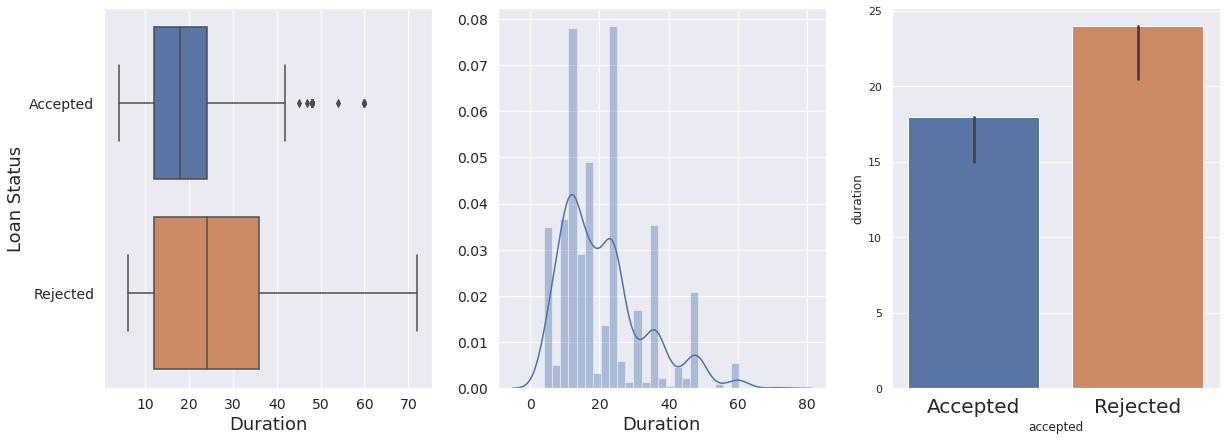

In [ ]:
plt.figure(figsize=[20,7])
plt.subplot(1,3,1)
createBoxPlot('duration', 'Duration', 'Loan Status', '')

plt.subplot(1,3,2)
createDistPlot('duration', 'Duration', '', '')

plt.subplot(1, 3, 3)
sns.barplot(x='accepted', y='duration', data=df, estimator=np.median)
plt.xticks(fontsize=20)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

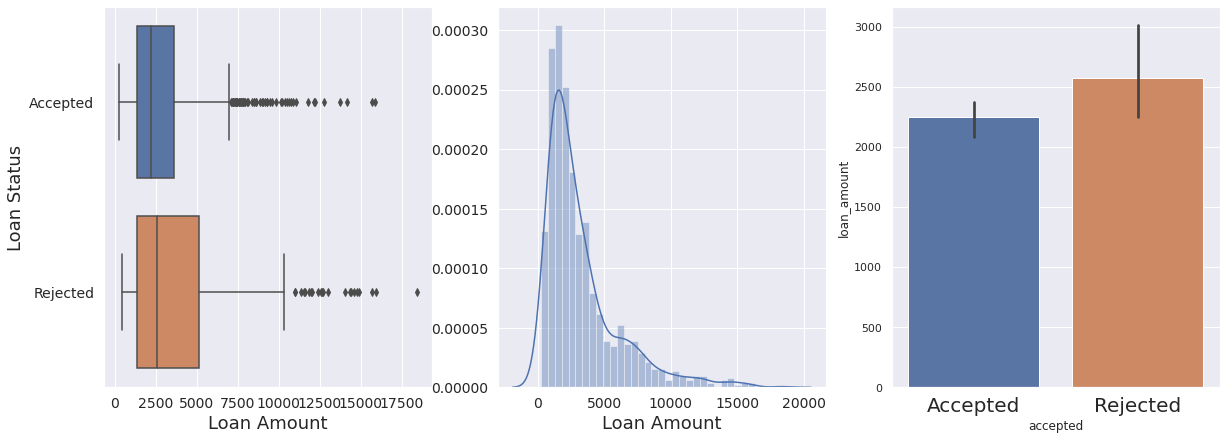

In [ ]:
plt.figure(figsize=[20,7])
plt.subplot(1,3,1)
createBoxPlot('loan_amount', 'Loan Amount', 'Loan Status', '')

plt.subplot(1,3,2)
createDistPlot('loan_amount', 'Loan Amount', '', '')

plt.subplot(1, 3, 3)
sns.barplot(x='accepted', y='loan_amount', data=df, estimator=np.median)
plt.xticks(fontsize=20)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

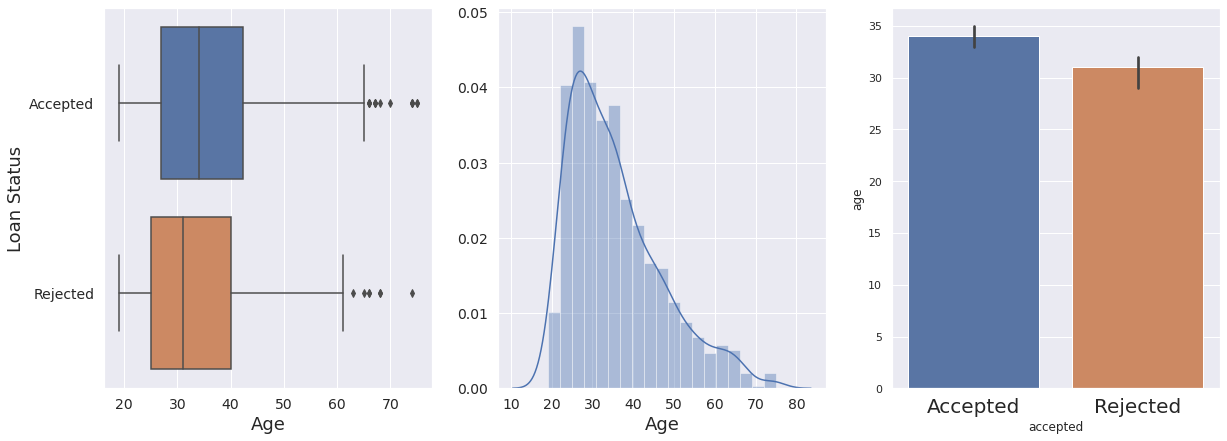

In [ ]:
plt.figure(figsize=[20,7])
plt.subplot(1,3,1)
createBoxPlot('age', 'Age', 'Loan Status', '')

plt.subplot(1,3,2)
createDistPlot('age', 'Age', '', '')

plt.subplot(1, 3, 3)
sns.barplot(x='accepted', y='age', data=df, estimator=np.median)
plt.xticks(fontsize=20)

In [ ]:
df['loan_amount'].describe(percentiles=[.95,.97])

count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
50%       2319.500000
95%       9162.700000
97%      10961.390000
max      18424.000000
Name: loan_amount, dtype: float64

### Univariate Analysis

In [ ]:
df

checking_status  duration  ...  gender              marital_status
0              <0DM         6  ...    male                      single
1        0_to_200DM        48  ...  female  divorced/separated/married
2              None        12  ...    male                      single
3              <0DM        42  ...    male                      single
4              <0DM        24  ...    male                      single
..              ...       ...  ...     ...                         ...
995            None        12  ...  female  divorced/separated/married
996            <0DM        30  ...    male          divorced/separated
997            None        12  ...    male                      single
998            <0DM        45  ...    male                      single
999      0_to_200DM        45  ...    male                      single

[1000 rows x 23 columns]

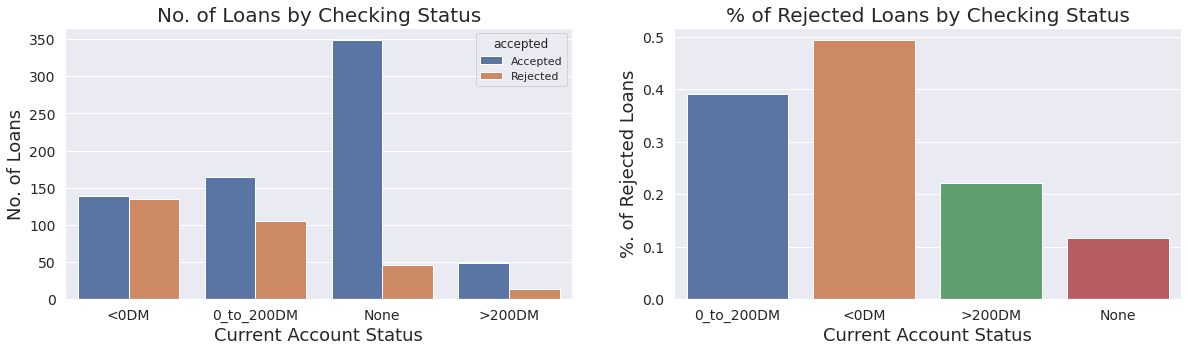

In [ ]:
plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
createCountPlot('checking_status', 'Current Account Status', 'No. of Loans', 'No. of Loans by Checking Status')

plt.subplot(1,2,2)
createPercPlot('checking_status', 'Current Account Status', '%. of Rejected Loans', '% of Rejected Loans by Checking Status')

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

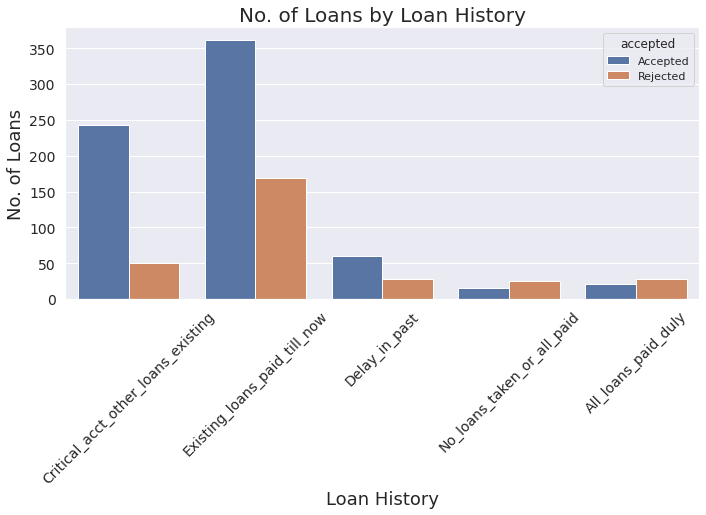

In [ ]:
plt.figure(figsize=[25,5])
plt.subplot(1,2,1)
createCountPlot('loan_history', 'Loan History', 'No. of Loans', 'No. of Loans by Loan History')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

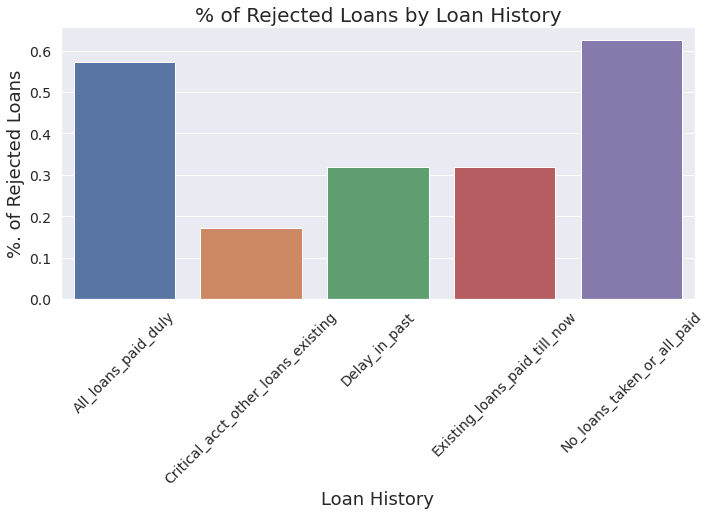

In [ ]:
plt.figure(figsize=[25,5])
plt.subplot(1,2,2)
createPercPlot('loan_history', 'Loan History', '%. of Rejected Loans', '% of Rejected Loans by Loan History')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

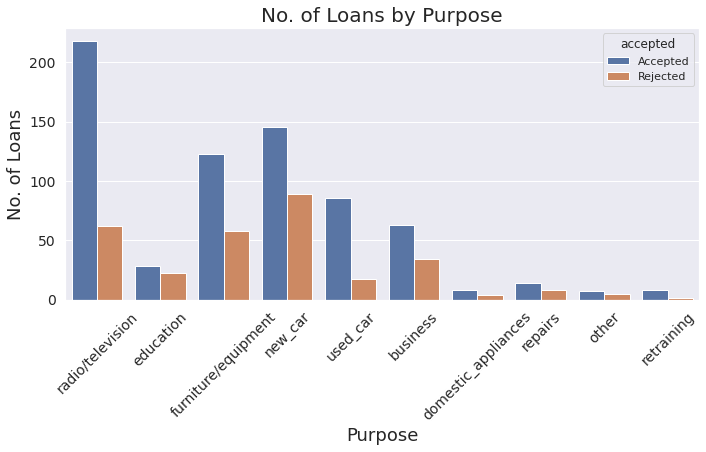

In [ ]:
plt.figure(figsize=[25,5])
plt.subplot(1,2,1)
createCountPlot('purpose', 'Purpose', 'No. of Loans', 'No. of Loans by Purpose')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

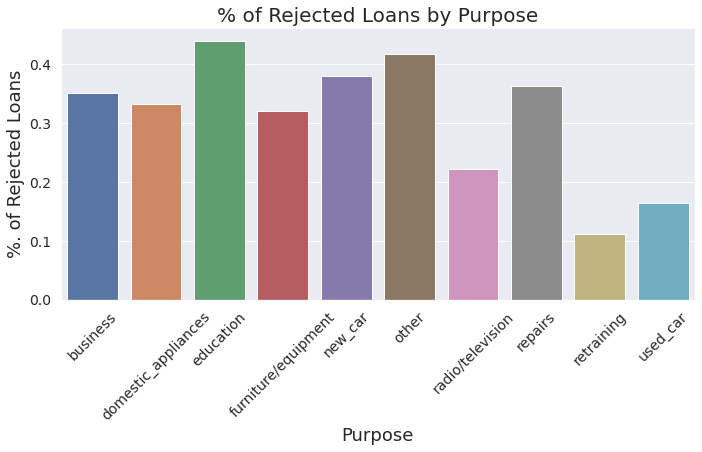

In [ ]:
plt.figure(figsize=[25,5])
plt.subplot(1,2,2)
createPercPlot('purpose', 'Purpose', '%. of Rejected Loans', '% of Rejected Loans by Purpose')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

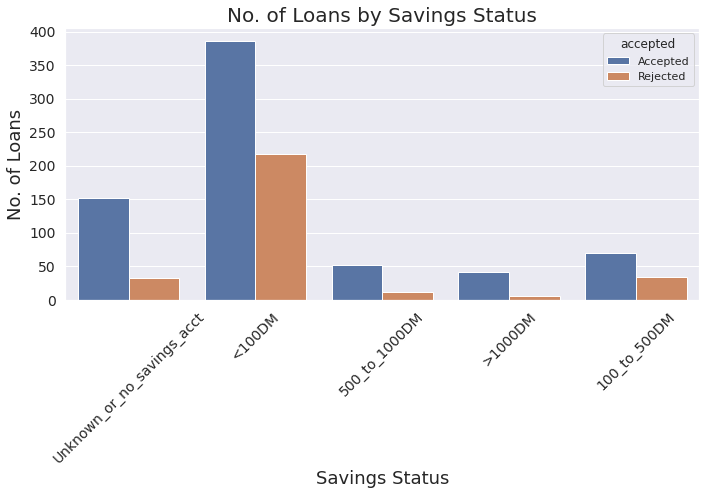

In [ ]:
plt.figure(figsize=[25,5])
plt.subplot(1,2,1)
createCountPlot('savings_status', 'Savings Status', 'No. of Loans', 'No. of Loans by Savings Status')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

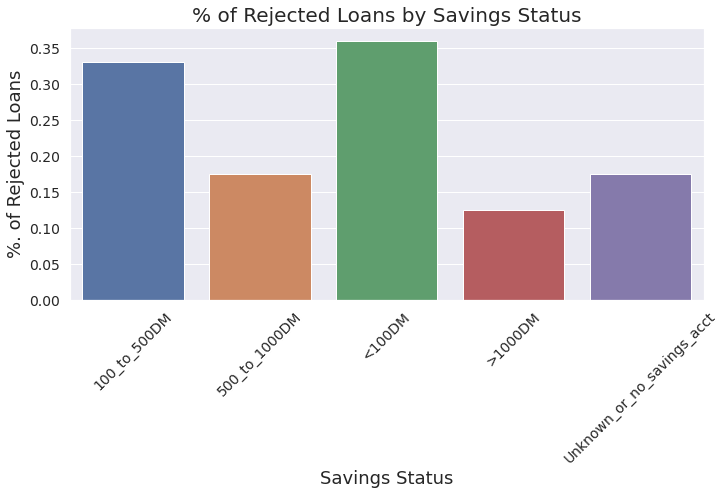

In [ ]:
plt.figure(figsize=[25,5])
plt.subplot(1,2,2)
createPercPlot('savings_status', 'Savings Status', '%. of Rejected Loans', '% of Rejected Loans by Savings Status')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

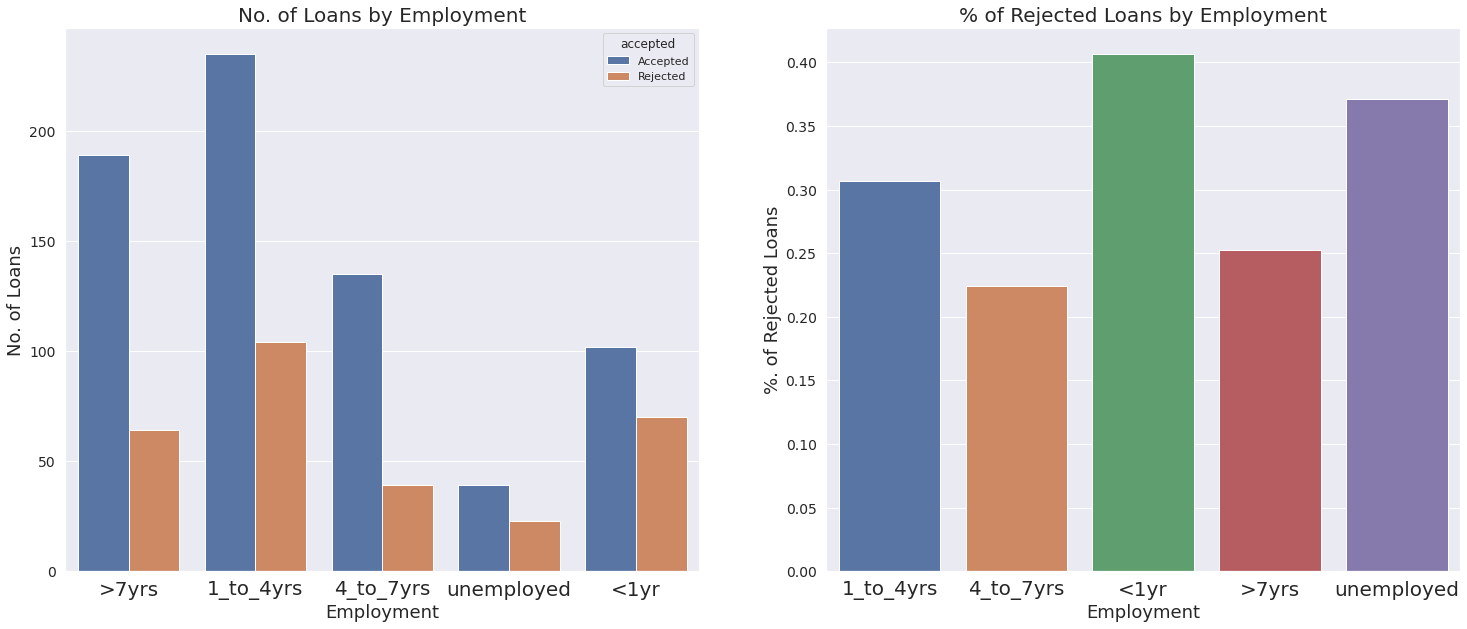

In [ ]:
plt.figure(figsize=[25,10])
plt.subplot(1,2,1)
createCountPlot('employment', 'Employment', 'No. of Loans', 'No. of Loans by Employment')
plt.xticks(fontsize=20)

plt.subplot(1,2,2)
createPercPlot('employment', 'Employment', '%. of Rejected Loans', '% of Rejected Loans by Employment')
plt.xticks(fontsize=20)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

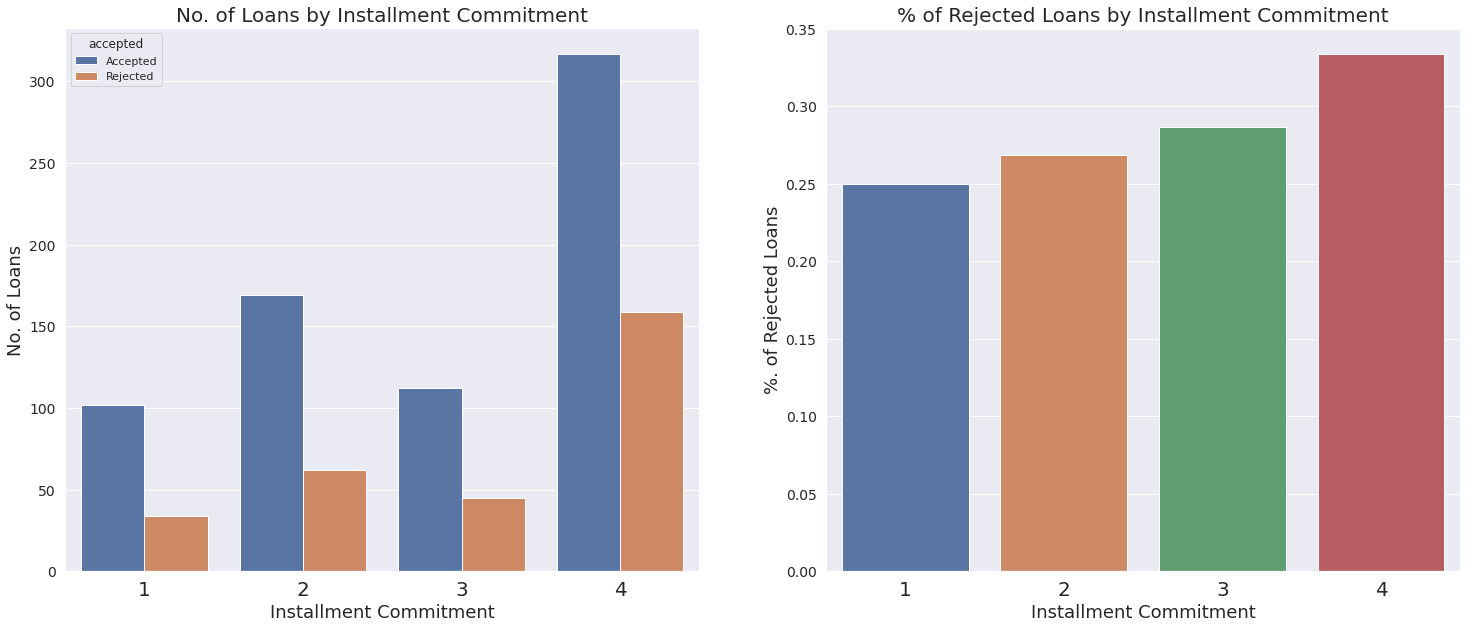

In [ ]:
plt.figure(figsize=[25,10])
plt.subplot(1,2,1)
createCountPlot('installment_commitment', 'Installment Commitment', 'No. of Loans', 'No. of Loans by Installment Commitment')
plt.xticks(fontsize=20)

plt.subplot(1,2,2)
createPercPlot('installment_commitment', 'Installment Commitment', '%. of Rejected Loans', '% of Rejected Loans by Installment Commitment')
plt.xticks(fontsize=20)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

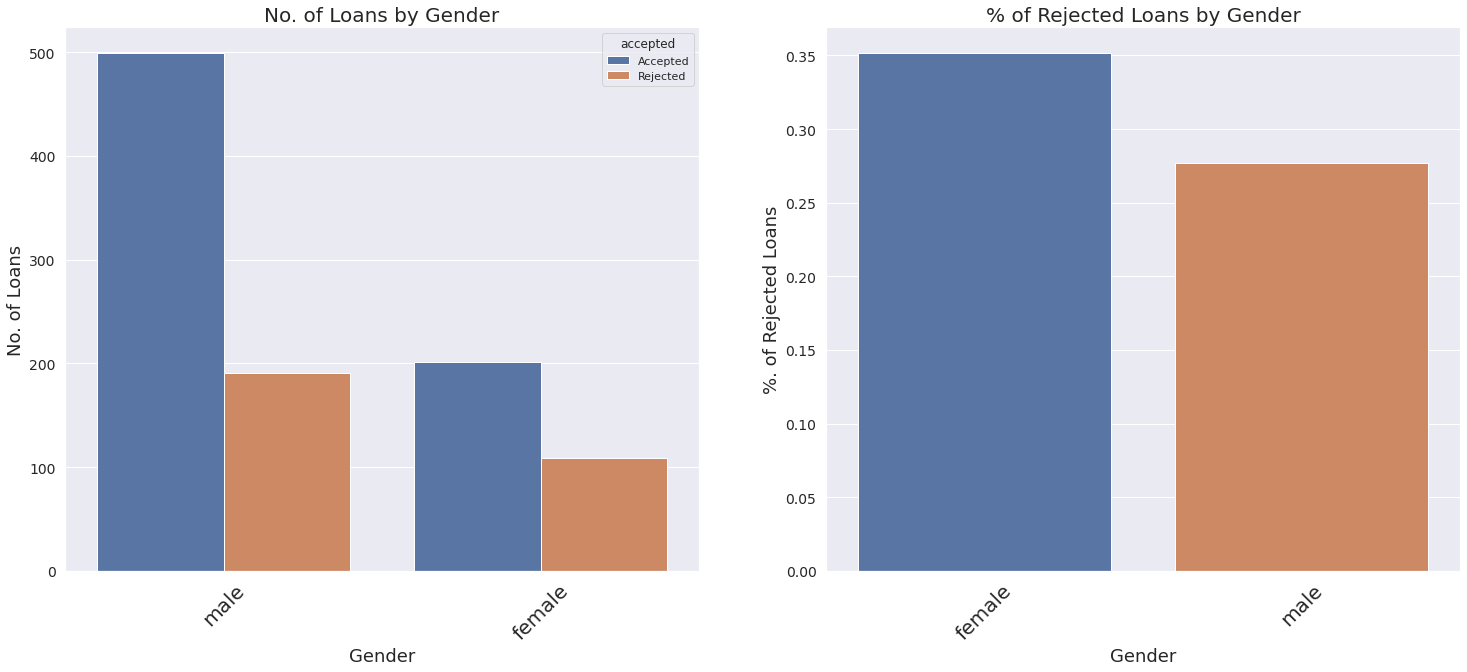

In [ ]:
plt.figure(figsize=[25,10])
plt.subplot(1,2,1)
createCountPlot('gender', 'Gender', 'No. of Loans', 'No. of Loans by Gender')
plt.xticks(rotation=45, fontsize=20)

plt.subplot(1,2,2)
createPercPlot('gender', 'Gender', '%. of Rejected Loans', '% of Rejected Loans by Gender')
plt.xticks(rotation=45, fontsize=20)

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

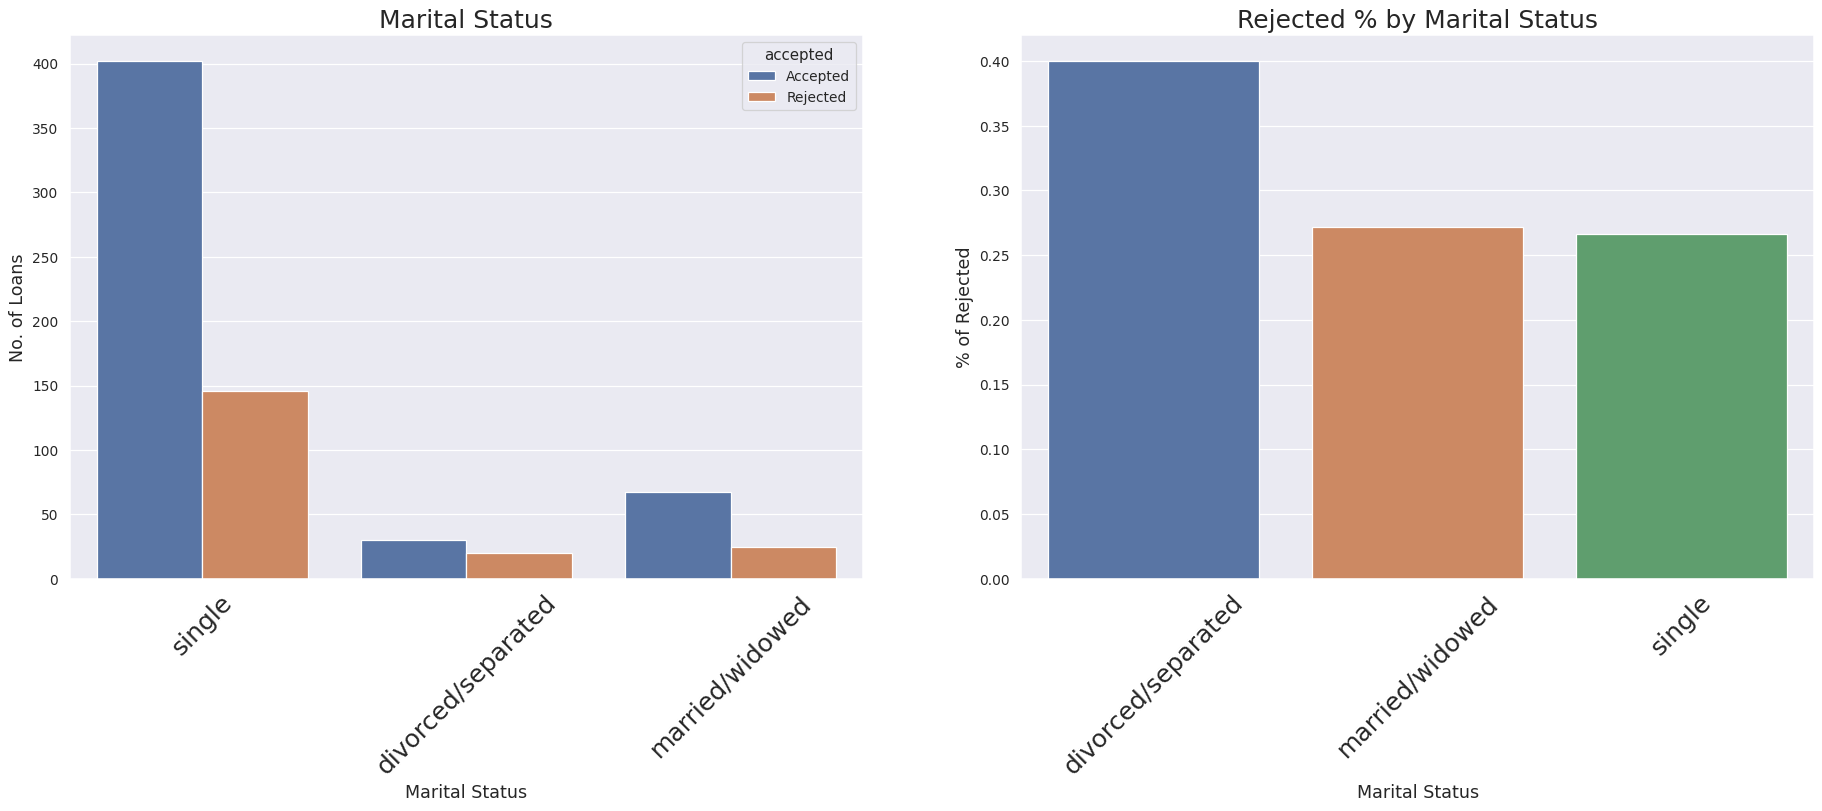

In [ ]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25,8), dpi=90)
sns.countplot('marital_status',hue='accepted',data=df[df['gender']=='male'],ax=ax1)
ax1.set_xlabel('Marital Status', fontsize=14)
ax1.set_ylabel('No. of Loans', fontsize=14)
ax1.set_title('Marital Status', fontsize=20)
charge_off_rates = df[df['gender']=='male'].groupby('marital_status')['accepted'].value_counts(normalize=True).loc[:,'Rejected']
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, ax=ax2)
ax2.set_xlabel('Marital Status', fontsize=14)
ax2.set_ylabel('% of Rejected', fontsize=14)
ax2.set_title('Rejected % by Marital Status', fontsize=20)
plt.sca(ax1)
plt.xticks(rotation=45, fontsize=20)
plt.sca(ax2)
plt.xticks(rotation=45, fontsize=20)

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

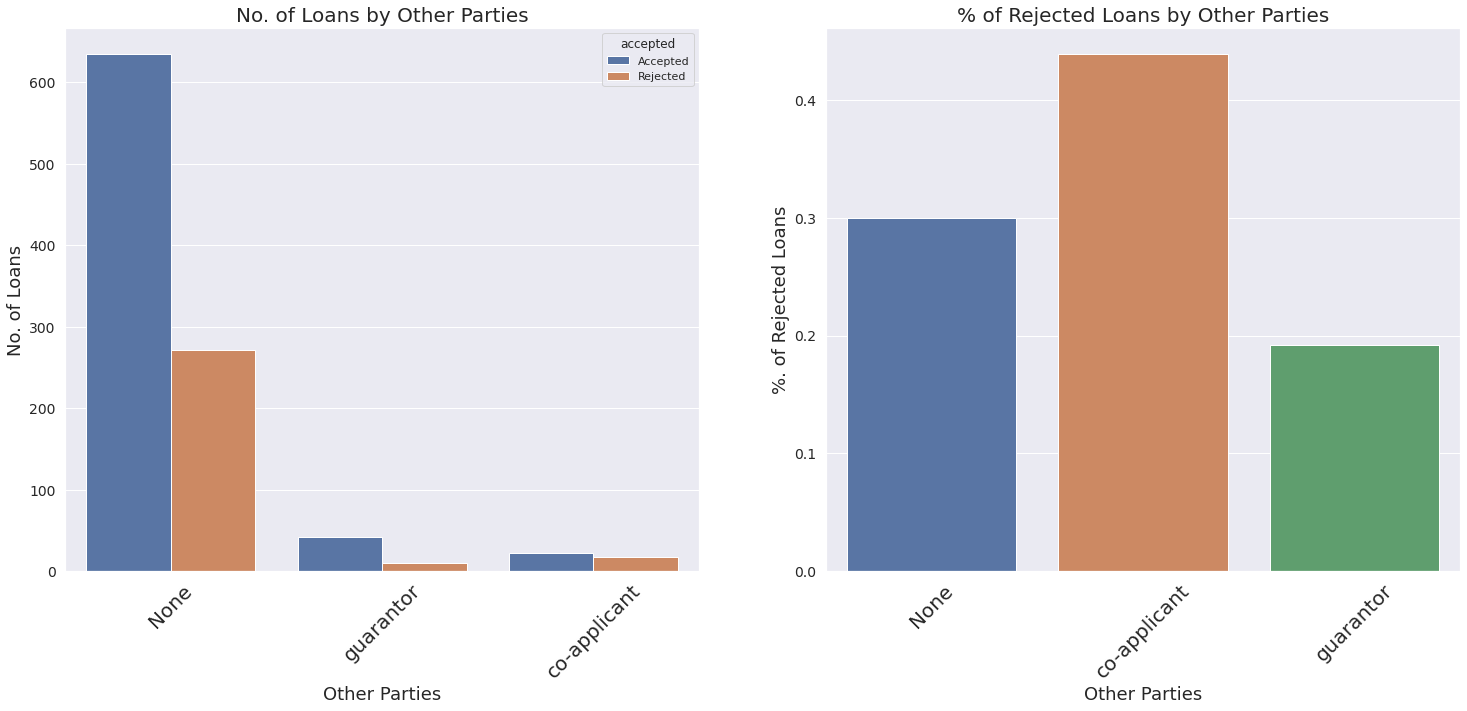

In [ ]:
plt.figure(figsize=[25,10])
plt.subplot(1,2,1)
createCountPlot('other_parties', 'Other Parties', 'No. of Loans', 'No. of Loans by Other Parties')
plt.xticks(rotation=45, fontsize=20)

plt.subplot(1,2,2)
createPercPlot('other_parties', 'Other Parties', '%. of Rejected Loans', '% of Rejected Loans by Other Parties')
plt.xticks(rotation=45, fontsize=20)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

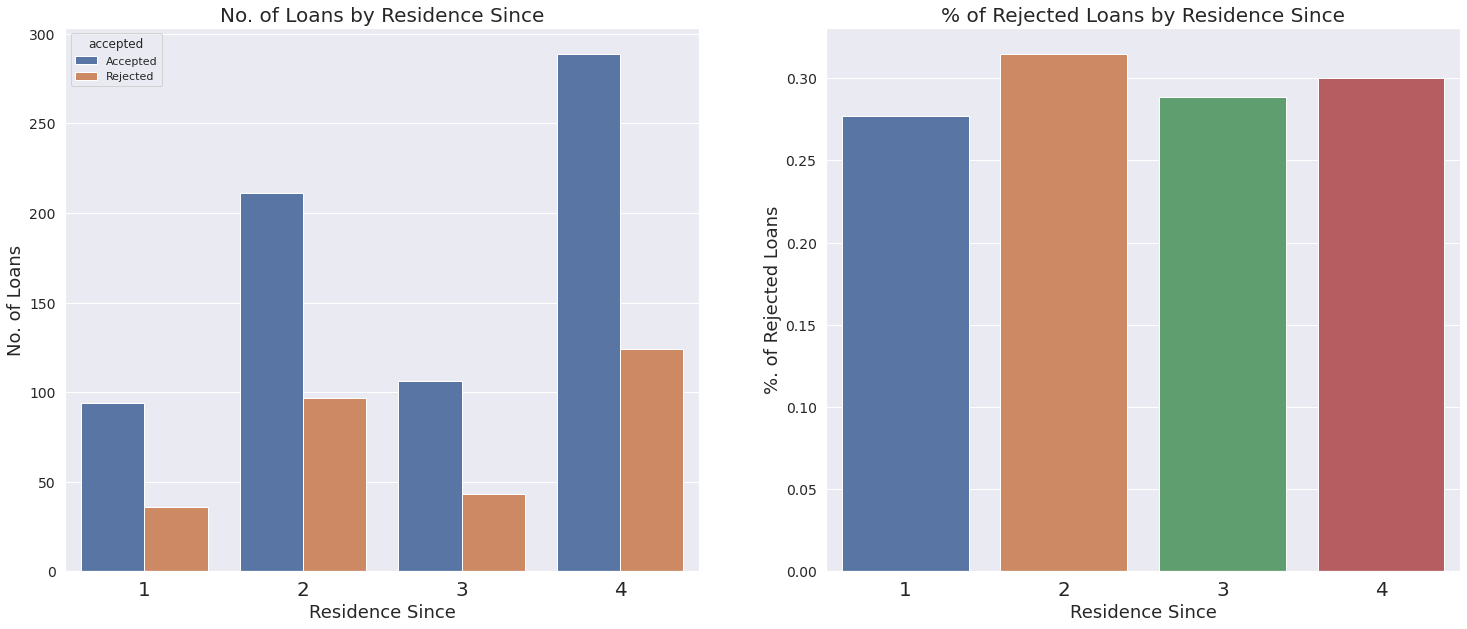

In [ ]:
plt.figure(figsize=[25,10])
plt.subplot(1,2,1)
createCountPlot('residence_since', 'Residence Since', 'No. of Loans', 'No. of Loans by Residence Since')
plt.xticks(fontsize=20)

plt.subplot(1,2,2)
createPercPlot('residence_since', 'Residence Since', '%. of Rejected Loans', '% of Rejected Loans by Residence Since')
plt.xticks(fontsize=20)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

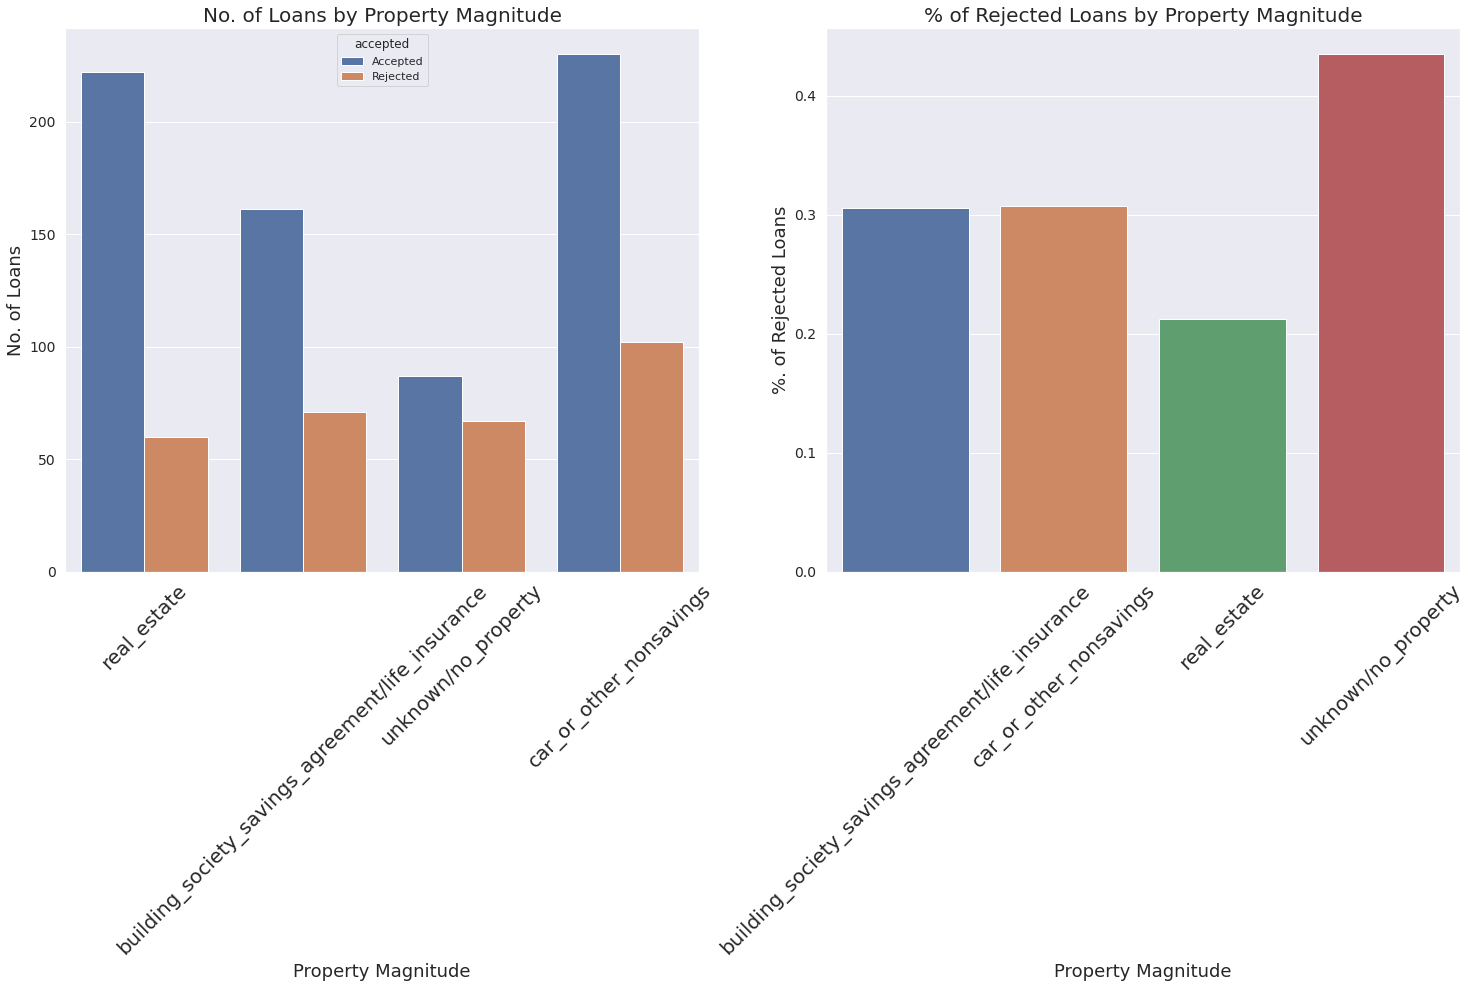

In [ ]:
plt.figure(figsize=[25,10])
plt.subplot(1,2,1)
createCountPlot('property_magnitude', 'Property Magnitude', 'No. of Loans', 'No. of Loans by Property Magnitude')
plt.xticks(rotation=45, fontsize=20)

plt.subplot(1,2,2)
createPercPlot('property_magnitude', 'Property Magnitude', '%. of Rejected Loans', '% of Rejected Loans by Property Magnitude')
plt.xticks(rotation=45, fontsize=20)

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

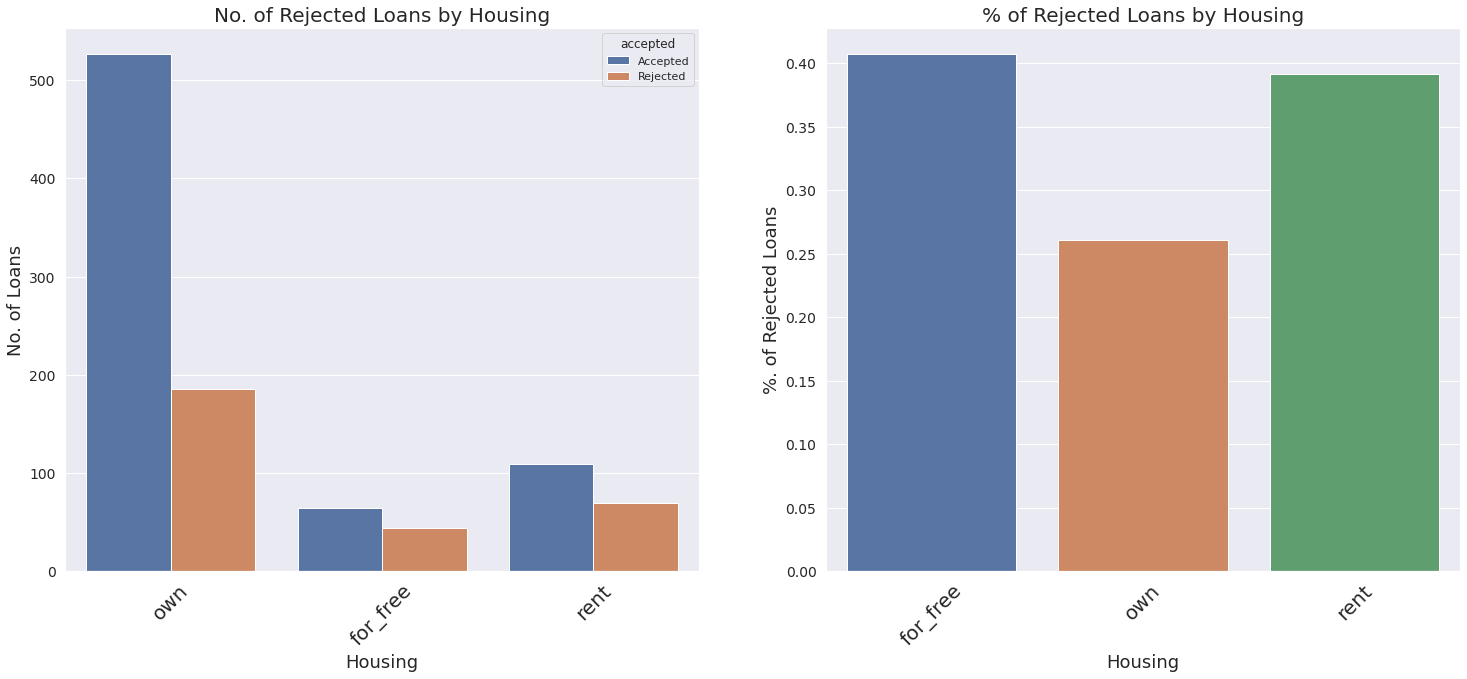

In [ ]:
plt.figure(figsize=[25,10])
plt.subplot(1,2,1)
createCountPlot('housing', 'Housing', 'No. of Loans', 'No. of Rejected Loans by Housing')
plt.xticks(rotation=45, fontsize=20)

plt.subplot(1,2,2)
createPercPlot('housing', 'Housing', '%. of Rejected Loans', '% of Rejected Loans by Housing')
plt.xticks(rotation=45, fontsize=20)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

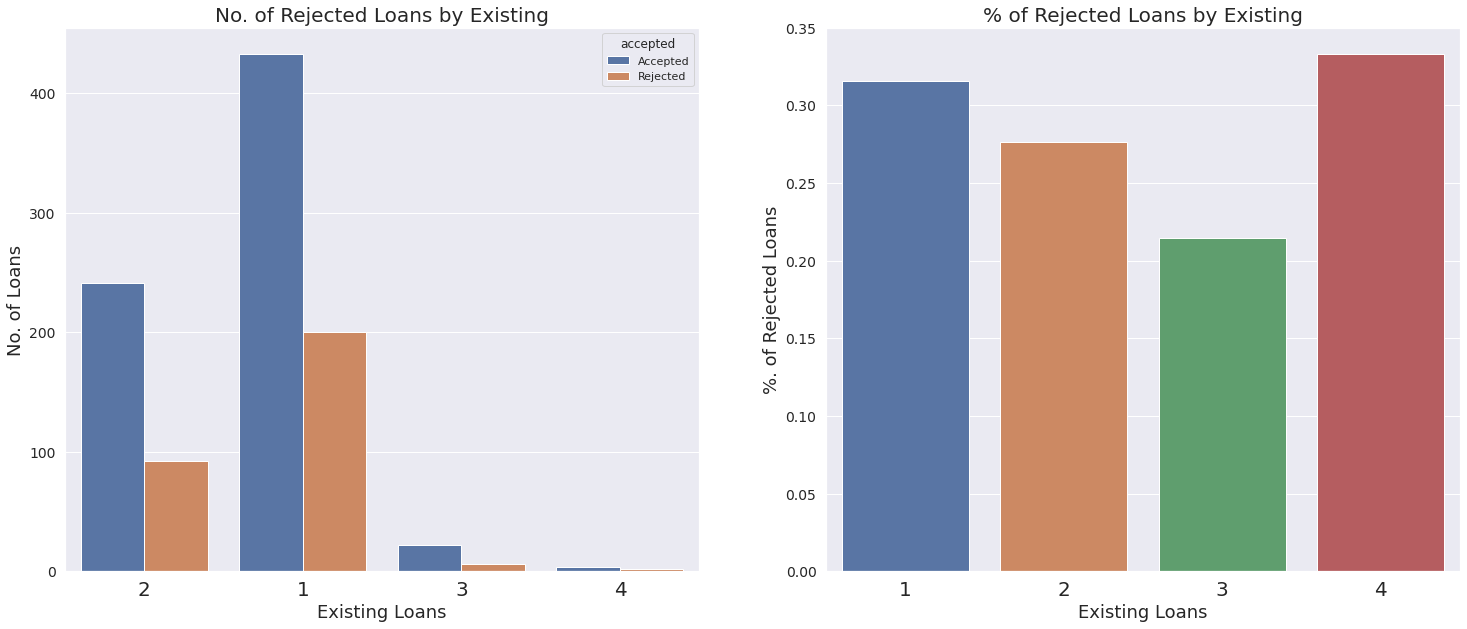

In [ ]:
plt.figure(figsize=[25,10])
plt.subplot(1,2,1)
createCountPlot('existing_loans', 'Existing Loans', 'No. of Loans', 'No. of Rejected Loans by Existing')
plt.xticks(fontsize=20)

plt.subplot(1,2,2)
createPercPlot('existing_loans', 'Existing Loans', '%. of Rejected Loans', '% of Rejected Loans by Existing')
plt.xticks(fontsize=20)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

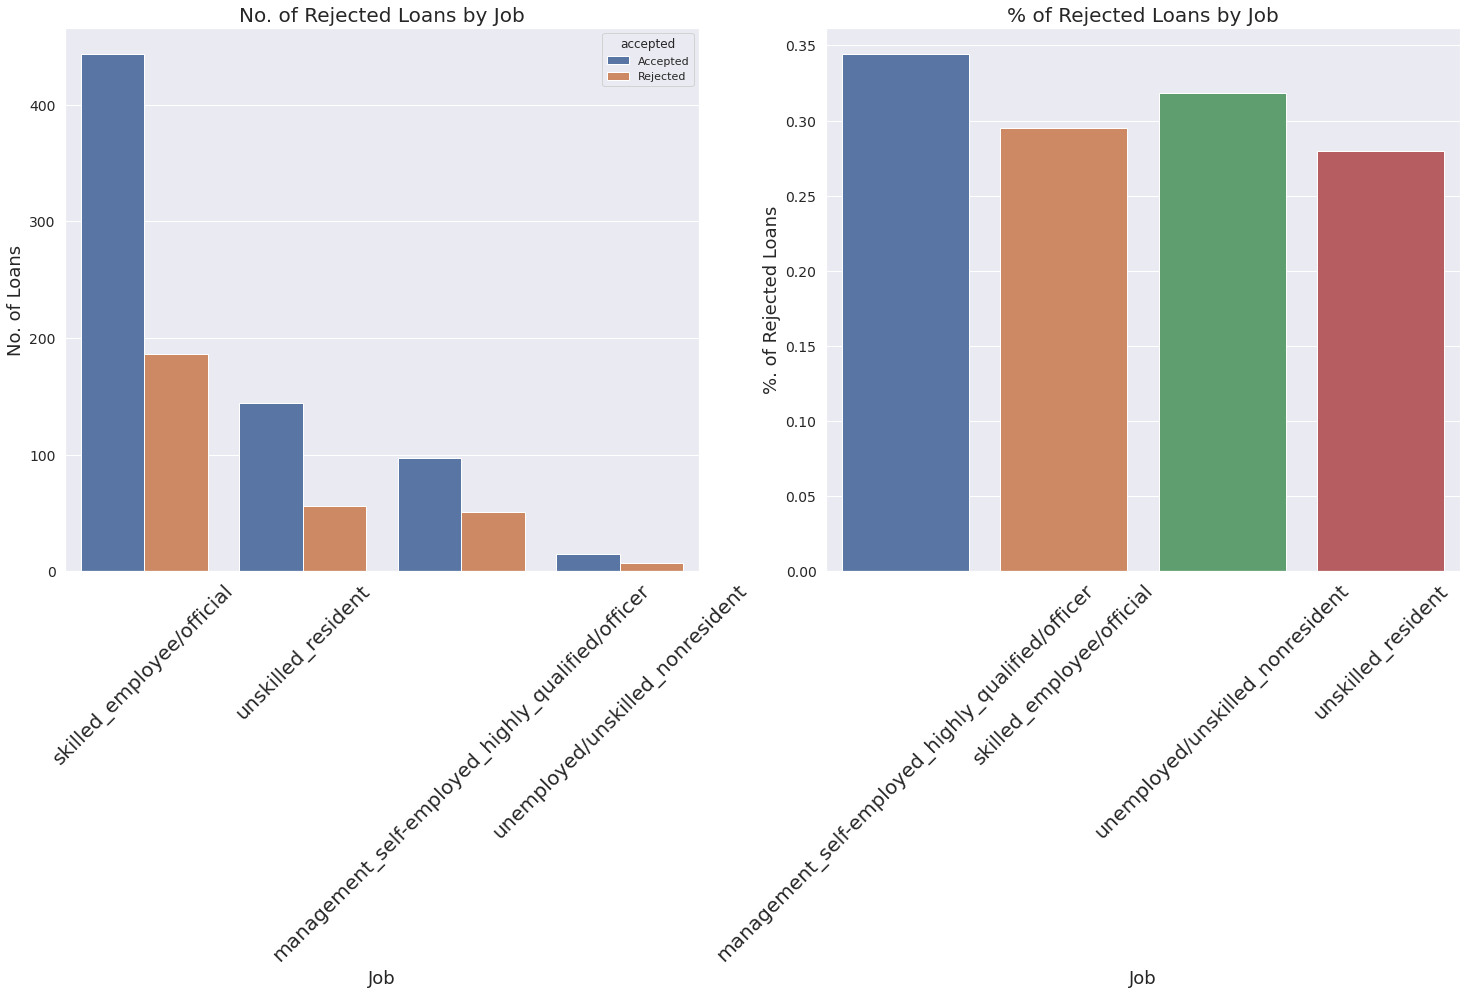

In [ ]:
plt.figure(figsize=[25,10])
plt.subplot(1,2,1)
createCountPlot('job', 'Job', 'No. of Loans', 'No. of Rejected Loans by Job')
plt.xticks(rotation=45, fontsize=20)

plt.subplot(1,2,2)
createPercPlot('job', 'Job', '%. of Rejected Loans', '% of Rejected Loans by Job')
plt.xticks(rotation=45, fontsize=20)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

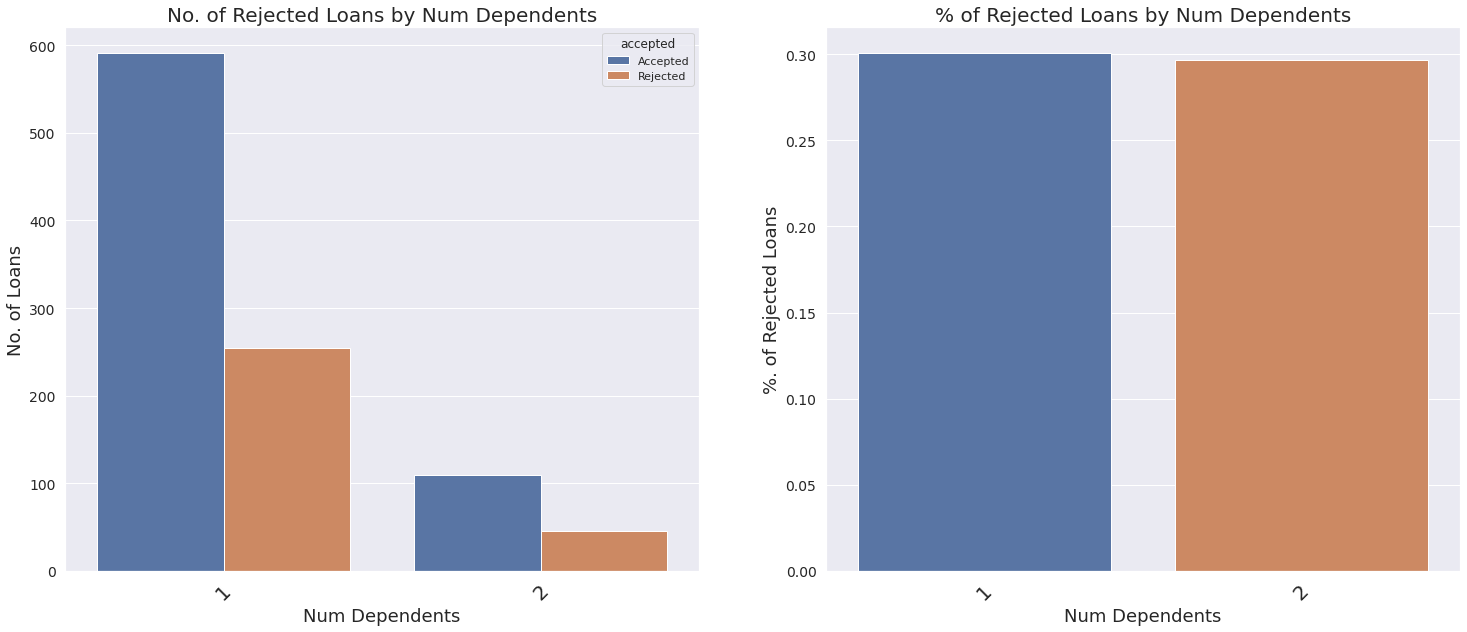

In [ ]:
plt.figure(figsize=[25,10])
plt.subplot(1,2,1)
createCountPlot('num_dependents', 'Num Dependents', 'No. of Loans', 'No. of Rejected Loans by Num Dependents')
plt.xticks(rotation=45, fontsize=20)

plt.subplot(1,2,2)
createPercPlot('num_dependents', 'Num Dependents', '%. of Rejected Loans', '% of Rejected Loans by Num Dependents')
plt.xticks(rotation=45, fontsize=20)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

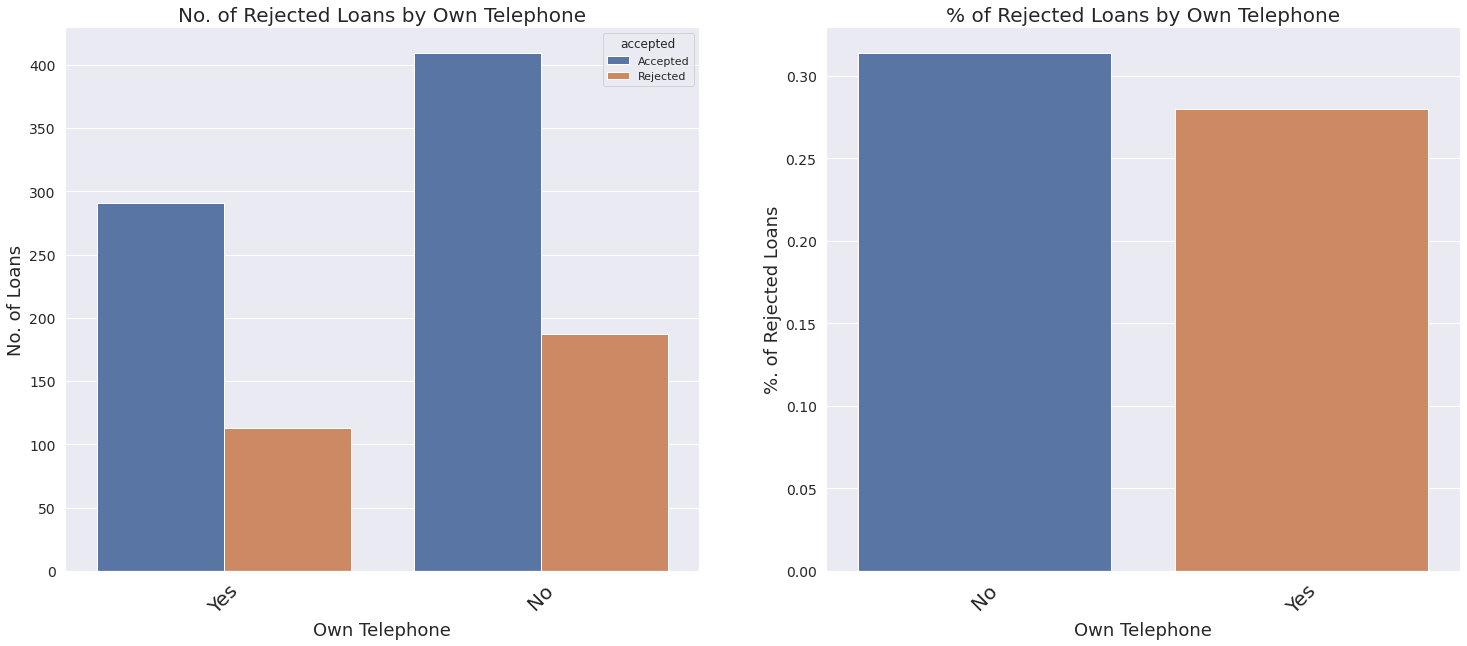

In [ ]:
plt.figure(figsize=[25,10])
plt.subplot(1,2,1)
createCountPlot('own_telephone', 'Own Telephone', 'No. of Loans', 'No. of Rejected Loans by Own Telephone')
plt.xticks(rotation=45, fontsize=20)

plt.subplot(1,2,2)
createPercPlot('own_telephone', 'Own Telephone', '%. of Rejected Loans', '% of Rejected Loans by Own Telephone')
plt.xticks(rotation=45, fontsize=20)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

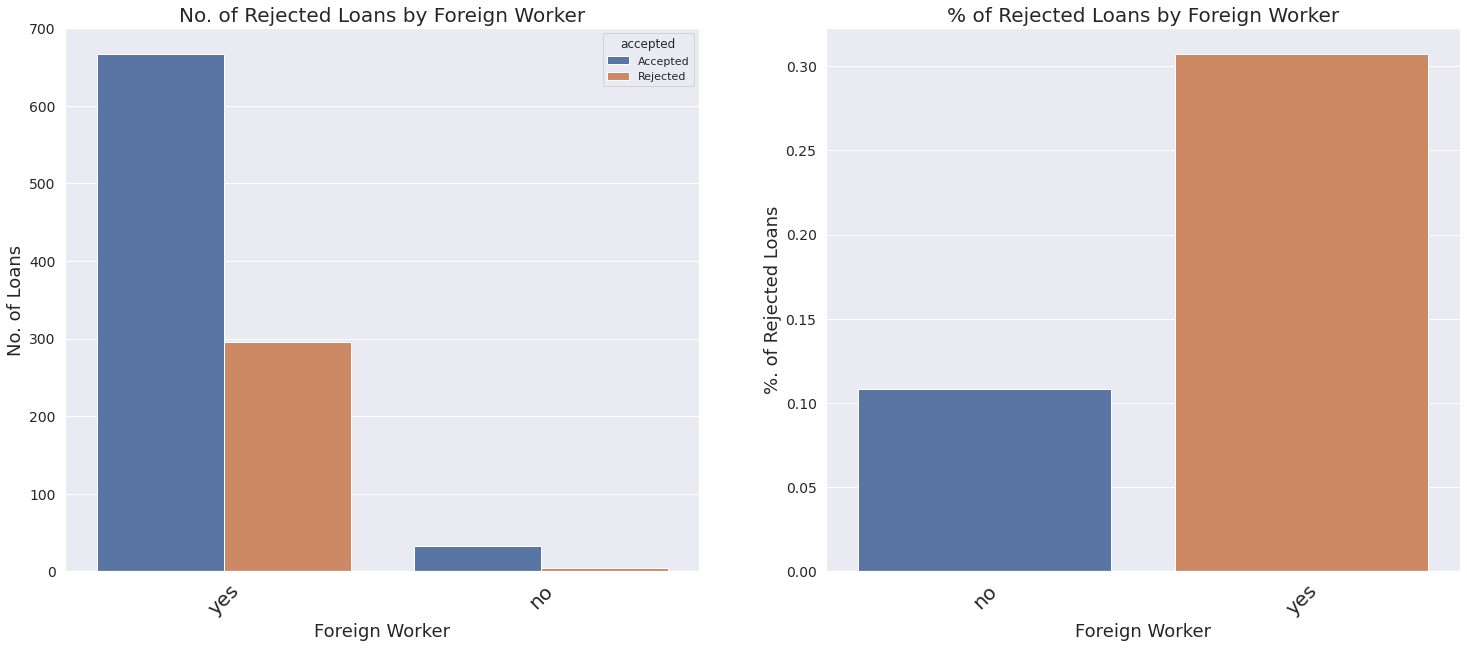

In [ ]:
plt.figure(figsize=[25,10])
plt.subplot(1,2,1)
createCountPlot('foreign_worker', 'Foreign Worker', 'No. of Loans', 'No. of Rejected Loans by Foreign Worker')
plt.xticks(rotation=45, fontsize=20)

plt.subplot(1,2,2)
createPercPlot('foreign_worker', 'Foreign Worker', '%. of Rejected Loans', '% of Rejected Loans by Foreign Worker')
plt.xticks(rotation=45, fontsize=20)

### Bivariate analysis

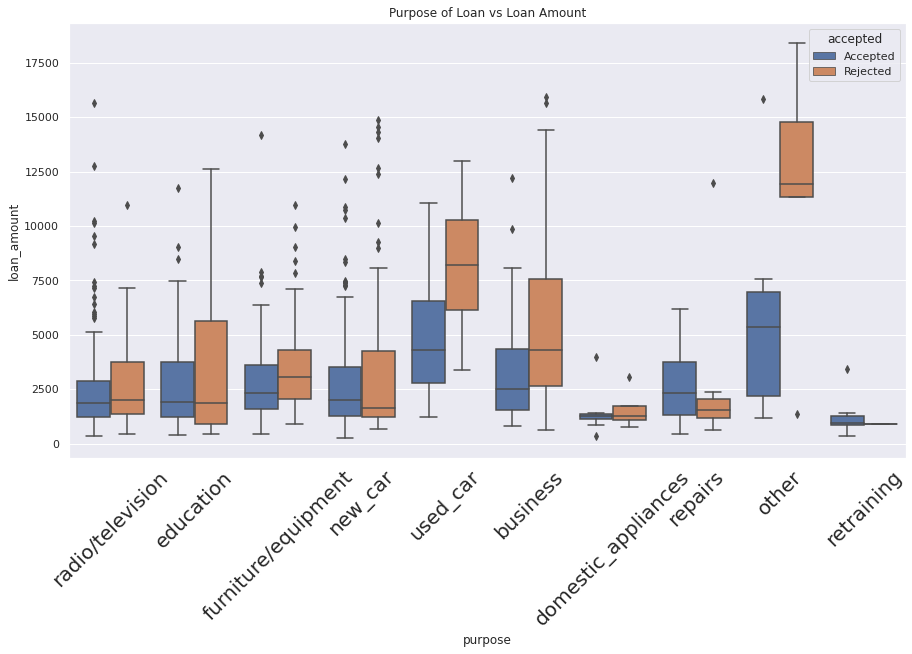

In [ ]:
plt.figure(figsize=(15,8))
sns.boxplot(data =df, x='purpose', y='loan_amount', hue ='accepted')
plt.title('Purpose of Loan vs Loan Amount')
plt.xticks(rotation = 45, fontsize=20)
plt.show()

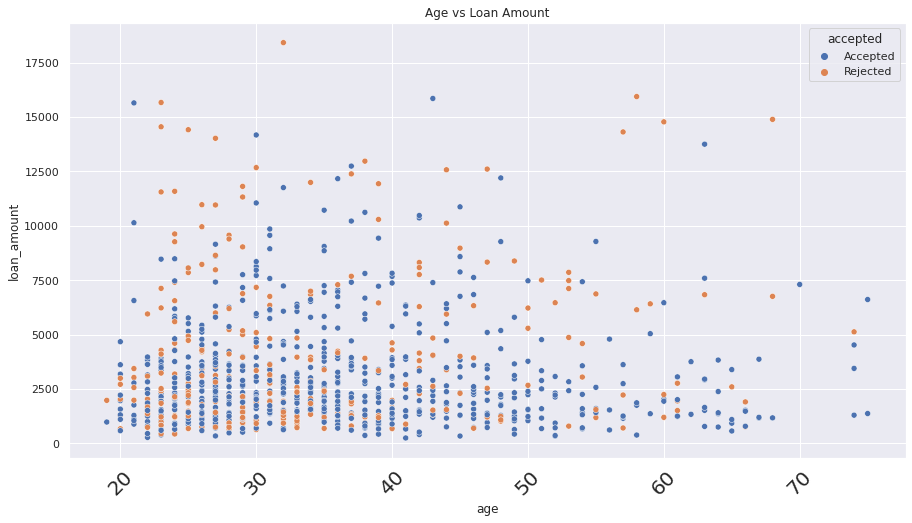

In [ ]:

plt.figure(figsize=(15,8))
sns.scatterplot(x='age',y='loan_amount',hue='accepted',data=df)
plt.title('Age vs Loan Amount')
plt.xticks(rotation = 45, fontsize=20)
plt.show()

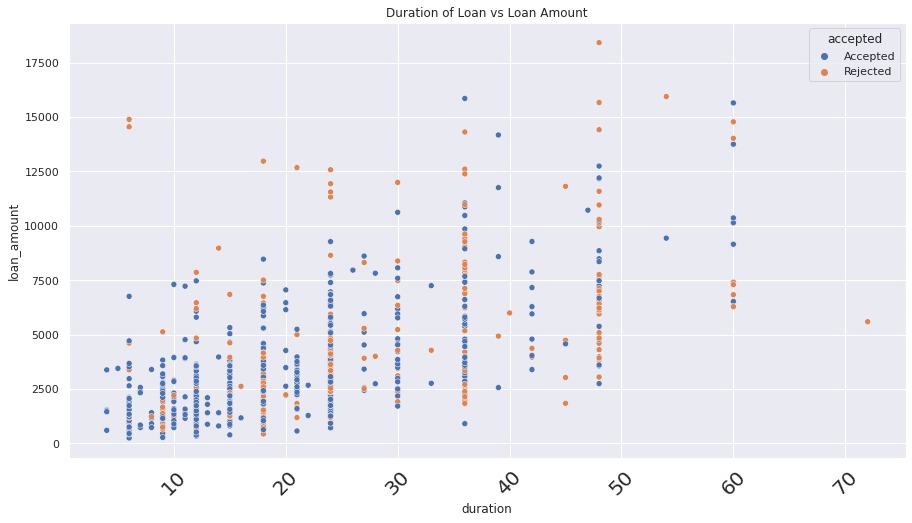

In [ ]:

plt.figure(figsize=(15,8))
sns.scatterplot(x='duration',y='loan_amount',hue='accepted',data=df)
plt.title('Duration of Loan vs Loan Amount')
plt.xticks(rotation = 45, fontsize=20)
plt.show()

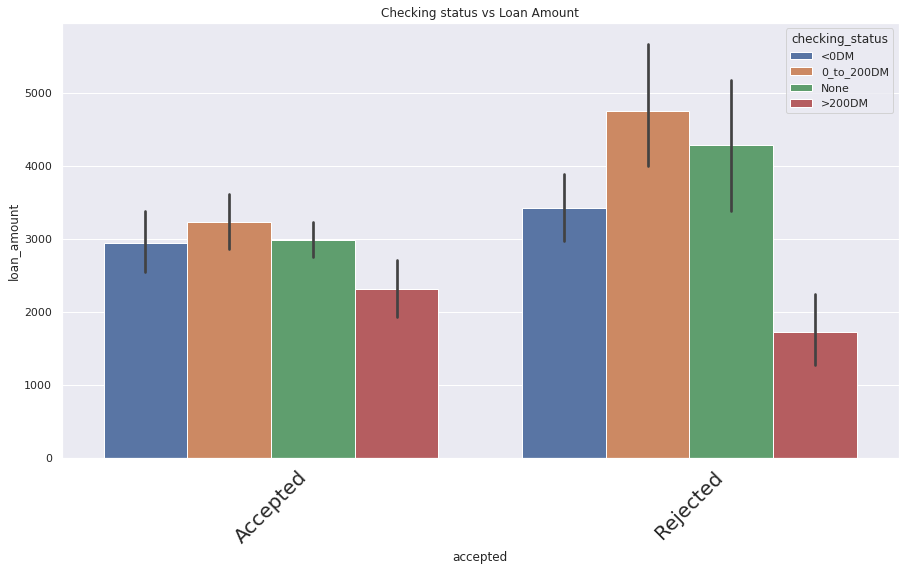

In [ ]:

plt.figure(figsize=(15,8))
sns.barplot(x='accepted',y='loan_amount',hue='checking_status',data=df)
plt.title('Checking status vs Loan Amount')
plt.xticks(rotation = 45, fontsize=20)
plt.show()


<Figure size 1080x576 with 0 Axes>

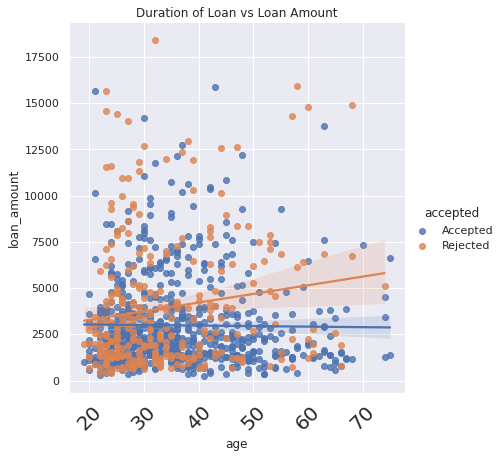

In [ ]:
plt.figure(figsize=(15,8))
sns.lmplot(x='age',y='loan_amount',hue='accepted',data=df,height=6, aspect=1)
plt.title('Duration of Loan vs Loan Amount')
plt.xticks(rotation = 45, fontsize=20)
plt.show()

<Figure size 1080x576 with 0 Axes>

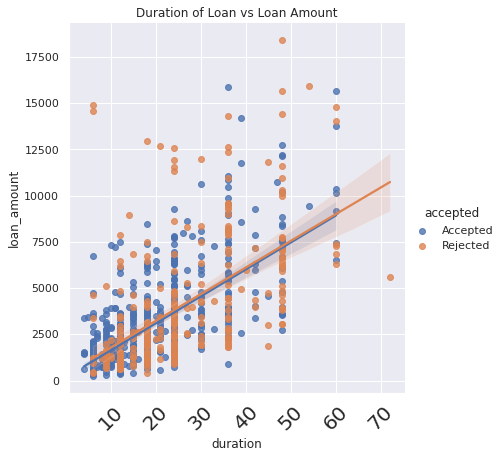

In [ ]:
plt.figure(figsize=(15,8))
sns.lmplot(x='duration',y='loan_amount',hue='accepted',data=df,height=6, aspect=1)
plt.title('Duration of Loan vs Loan Amount')
plt.xticks(rotation = 45, fontsize=20)
plt.show()

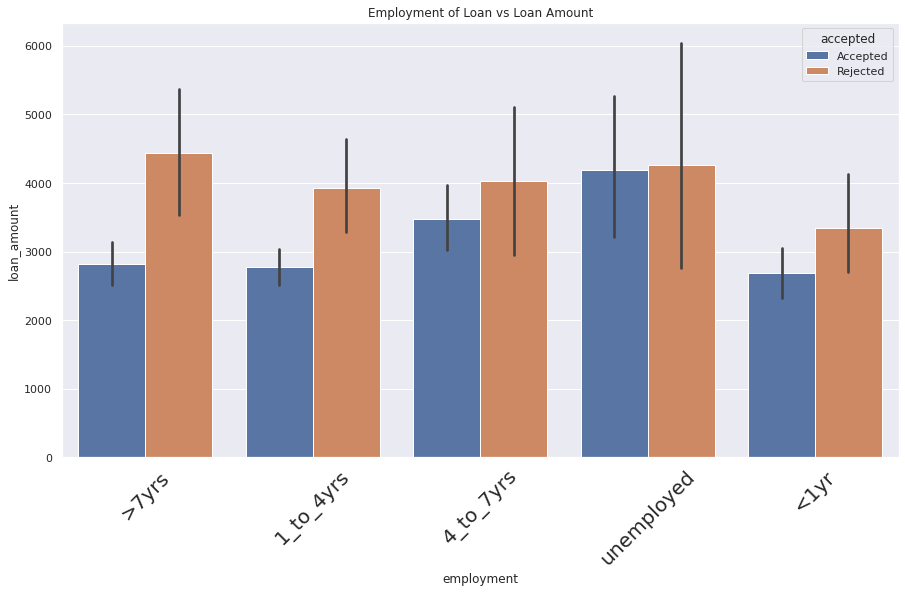

In [ ]:

plt.figure(figsize=(15,8))
sns.barplot(x='employment',y='loan_amount',hue='accepted',data=df)
plt.title('Employment of Loan vs Loan Amount')
plt.xticks(rotation = 45, fontsize=20)
plt.show()


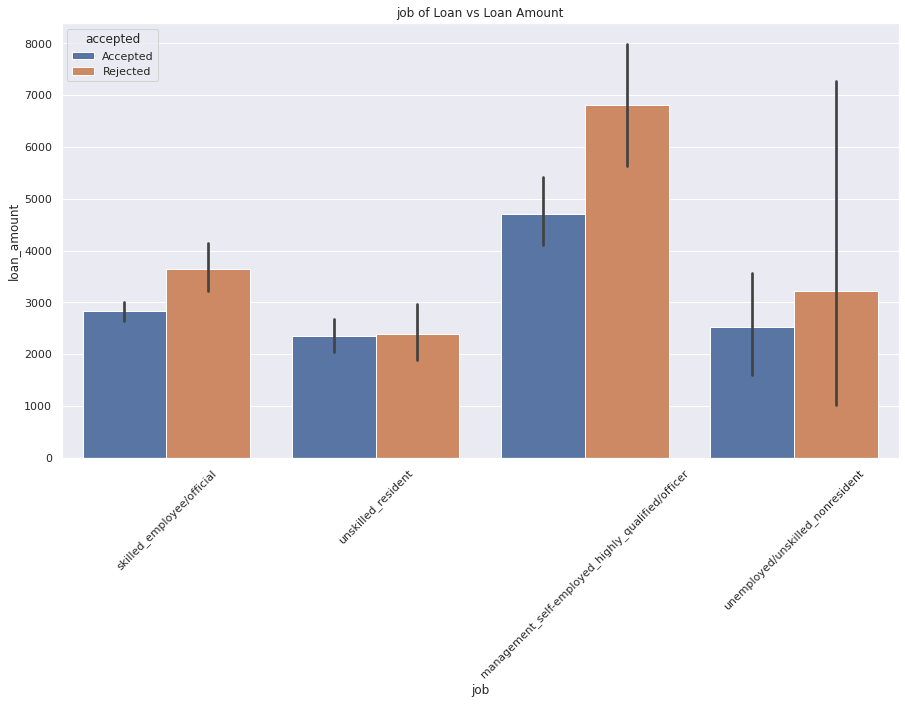

In [ ]:

plt.figure(figsize=(15,8))
sns.barplot(x='job',y='loan_amount',hue='accepted',data=df)
plt.title('job of Loan vs Loan Amount')
plt.xticks(rotation = 45)
plt.show()


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

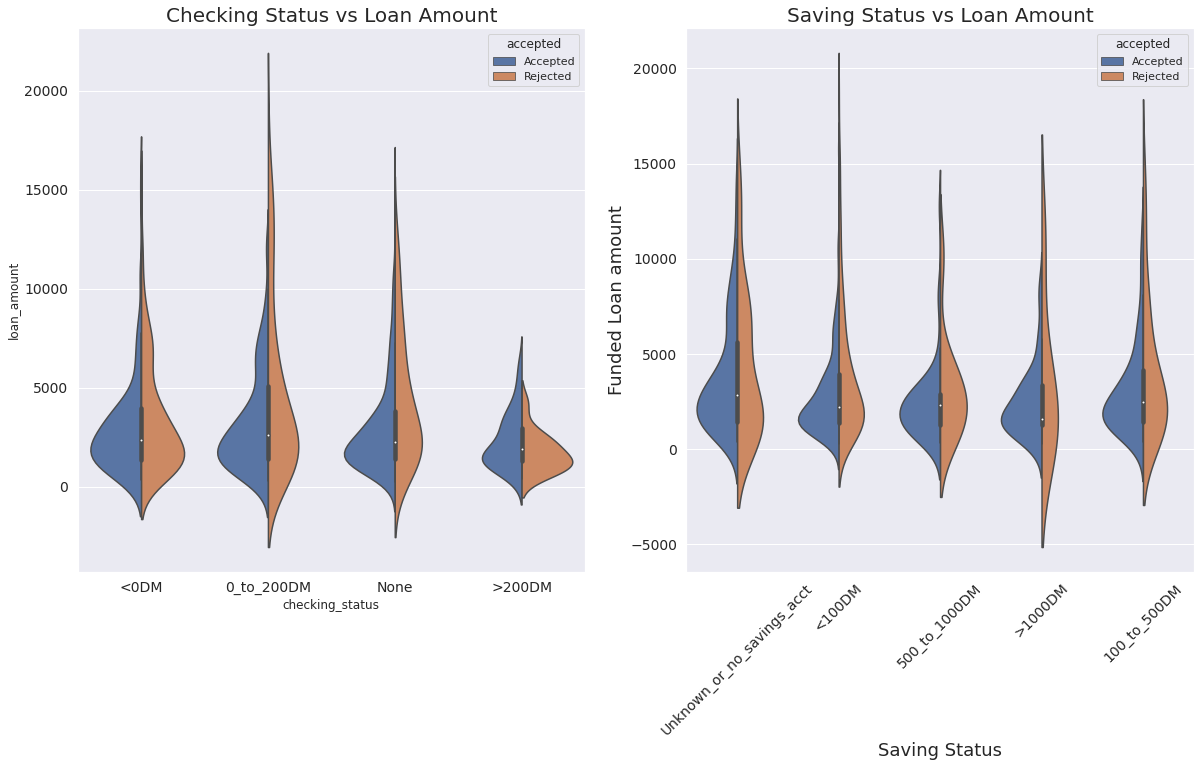

In [ ]:
fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(20,10))
plot1 = sns.violinplot(x="checking_status", y="loan_amount", data=df, hue='accepted',split=True,ax=ax1 )
plot2 = sns.violinplot(x="savings_status", y="loan_amount", data=df, hue='accepted',split=True,ax=ax2 )
setLabels(plot1, 'Checking Status', 'Fun`bded Loan amount', 'Checking Status vs Loan Amount')
setLabels(plot2, 'Saving Status', 'Funded Loan amount', 'Saving Status vs Loan Amount')
plt.xticks(rotation = 45)

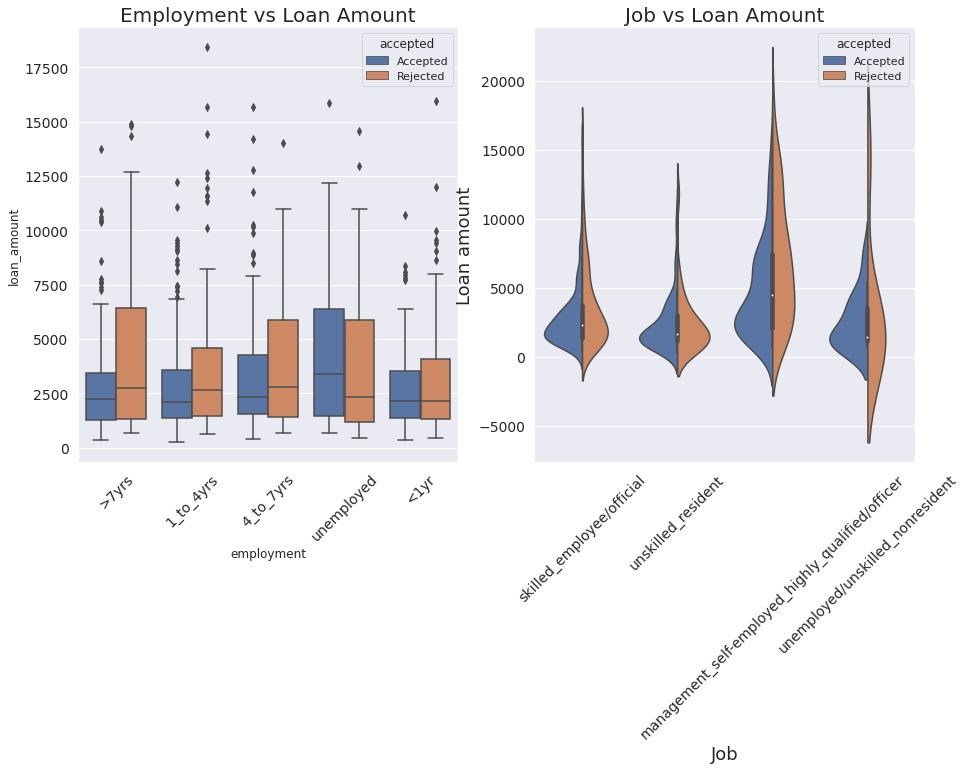

In [ ]:
fig, (ax1,ax2)= plt.subplots(nrows=1, ncols=2, figsize=(15,8))
plot1 = sns.boxplot(data =df, x='employment', y='loan_amount', hue ='accepted',ax=ax1)

setLabels(plot1, 'Employment', 'Loan amount', 'Employment vs Loan Amount')
plt.sca(ax1)
plt.xticks(rotation=45, fontsize=14)
# plt.yticks(fontsize=14)

plot2 = sns.violinplot(x="job", y="loan_amount", data=df, hue='accepted',split=True,ax=ax2 )
plt.sca(ax2)
plt.xticks(rotation=45, fontsize =14)
# plt.yticks(fontsize=14)
setLabels(plot2, 'Job', 'Loan amount', 'Job vs Loan Amount')

### Modeling

In [ ]:
df_model = df[['age','checking_status','duration','loan_amount','installment_commitment','accepted']]

In [ ]:
df_model['accepted'] = df['accepted'].apply(lambda x: 0 if x=='Rejected' else 1)

In [ ]:
df_model['checking_status'].unique()

array(['<0DM', '0_to_200DM', 'None', '>200DM'], dtype=object)

In [ ]:
df_model['checking_status'].value_counts(normalize=True)

None          0.394
<0DM          0.274
0_to_200DM    0.269
>200DM        0.063
Name: checking_status, dtype: float64

In [ ]:
checking_status_rates = pd.DataFrame(df_model['checking_status'].value_counts(normalize=True))

In [ ]:
df_model = pd.merge(df_model,checking_status_rates,left_on='checking_status',right_on=checking_status_rates.index,how='left')

In [ ]:
df_model.drop(['checking_status','checking_status_x'],axis=1,inplace=True)

In [ ]:
df_model.rename({'checking_status_y':'checking_status'},axis=1,inplace=True)

In [ ]:
df_model

age  duration  ...  accepted  checking_status
0     67         6  ...         1            0.274
1     22        48  ...         0            0.269
2     49        12  ...         1            0.394
3     45        42  ...         1            0.274
4     53        24  ...         0            0.274
..   ...       ...  ...       ...              ...
995   31        12  ...         1            0.394
996   40        30  ...         1            0.274
997   38        12  ...         1            0.394
998   23        45  ...         0            0.274
999   27        45  ...         1            0.269

[1000 rows x 6 columns]

In [ ]:
df_model_correlation = df_model.select_dtypes(exclude=["object"]).corr()
df_model_correlation

age  duration  ...  accepted  checking_status
age                     1.000000 -0.036136  ...  0.091127         0.022192
duration               -0.036136  1.000000  ... -0.214927        -0.000004
loan_amount             0.032716  0.624984  ... -0.154739         0.029862
installment_commitment  0.058266  0.074749  ... -0.072404         0.043081
accepted                0.091127 -0.214927  ...  1.000000         0.196377
checking_status         0.022192 -0.000004  ...  0.196377         1.000000

[6 rows x 6 columns]

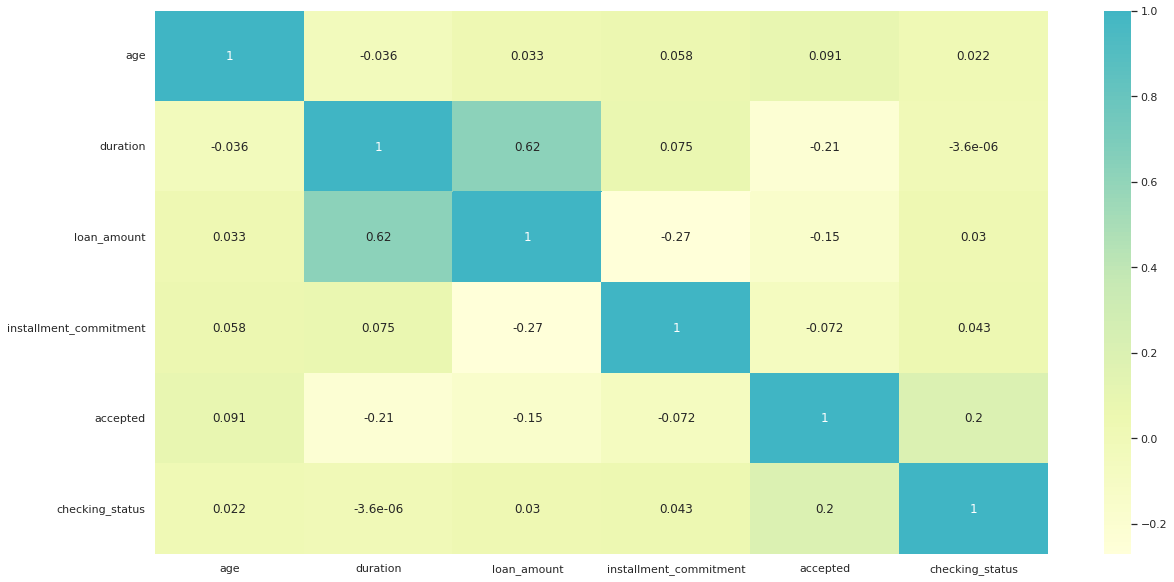

In [ ]:
plt.figure(figsize=(20, 10))
cols = df_model.columns.values

sns.heatmap(df_model_correlation,xticklabels=cols,yticklabels=cols,annot= True,center=1,cmap="YlGnBu")


In [ ]:
X = df_model.drop(['accepted'], axis = 1)
y = df_model['accepted']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 100, stratify=y)

In [ ]:
rf = RandomForestClassifier(n_estimators=100,class_weight = 'balanced')
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print("Accuracy",accuracy_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("F1 score",f1_score(y_test, y_pred))

Accuracy 0.7466666666666667
Recall: 0.8714285714285714
Precision: 0.7887931034482759
F1 score 0.828054298642534


In [ ]:
# Build GridSearchCV to find optimal hyperparameters
model = RandomForestClassifier(class_weight = "balanced", n_jobs = -1)
params = {'n_estimators':[50,100, 150, 250,300],
          'max_features':[None, 0.3, 0.5, 0.7],
          'max_depth':[4, 6, 9]
          }
n_folds = StratifiedKFold(n_splits = 10, random_state = 100)
gridmodel = GridSearchCV(estimator = model,
                         param_grid = params,
                         cv = n_folds,
                         scoring = 'f1',
                         n_jobs = -1)

In [ ]:
gridmodel.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=100, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                     

In [ ]:
gridmodel.best_params_

{'max_depth': 9, 'max_features': 0.3, 'n_estimators': 50}

In [ ]:
cv_results = pd.DataFrame(gridmodel.cv_results_)
cv_results

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0        0.200340      0.042206  ...        0.057508               60
1        0.352236      0.027631  ...        0.045594               43
2        0.517953      0.002409  ...        0.058883               58
3        0.778142      0.027760  ...        0.051783               53
4        0.918855      0.022894  ...        0.056019               54
5        0.146873      0.029809  ...        0.055560               45
6        0.274106      0.012013  ...        0.051321               42
7        0.419025      0.013234  ...        0.043695               50
8        0.693126      0.018152  ...        0.041555               41
9        0.836579      0.017545  ...        0.052513               52
10       0.133140      0.011795  ...        0.049401               49
11       0.283841      0.035132  ...        0.055303               51
12       0.414259      0.023605  ...        0.044313               46
13       0.692879      0.016437  ...        0.051515               47
14       0.828511      0.036139  ...        0.049224               48
15       0.155036      0.044550  ...        0.050613               57
16       0.297984      0.037382  ...        0.060618               59
17       0.437299      0.029408  ...        0.047004               56
18       0.742740      0.055681  ...        0.052014               44
19       0.856436      0.050105  ...        0.049491               55
20       0.228080      0.030044  ...        0.049552               34
21       0.350807      0.033333  ...        0.038702               21
22       0.525033      0.007526  ...        0.051441               27
23       0.830150      0.058977  ...        0.036941               25
24       1.009282      0.048232  ...        0.033789               29
25       0.189352      0.046584  ...        0.044015               23
26       0.272024      0.018209  ...        0.051963               40
27       0.421006      0.012928  ...        0.044201               28
28       0.699424      0.017972  ...        0.039608               22
29       0.838085      0.011598  ...        0.045955               32
30       0.186007      0.043851  ...        0.057403               38
31       0.299235      0.036572  ...        0.058275               31
32       0.435034      0.040434  ...        0.040728               33
33       0.715677      0.034693  ...        0.042349               39
34       0.850363      0.040942  ...        0.053661               37
35       0.210545      0.037704  ...        0.044282               35
36       0.328262      0.036196  ...        0.034668               36
37       0.489699      0.036332  ...        0.040405               24
38       0.772905      0.026205  ...        0.037557               26
39       0.928158      0.025918  ...        0.037309               30
40       0.237908      0.011606  ...        0.040459               13
41       0.370710      0.009370  ...        0.039734               17
42       0.519134      0.017619  ...        0.042218                2
43       0.897470      0.010697  ...        0.038963                5
44       1.065468      0.038856  ...        0.036210               10
45       0.191389      0.052094  ...        0.053004                1
46       0.290334      0.035097  ...        0.042482               20
47       0.452208      0.060440  ...        0.041600                7
48       0.732863      0.039101  ...        0.044900               14
49       0.873139      0.039639  ...        0.046542               18
50       0.142352      0.030518  ...        0.037014               19
51       0.338774      0.044864  ...        0.034864                9
52       0.477406      0.045739  ...        0.039930                3
53       0.780596      0.036908  ...        0.037915               15
54       0.947461      0.011834  ...        0.048168                8
55       0.237566      0.033244  ...        0.050587               16
56       0.347

In [ ]:
cv_results[cv_results['rank_test_score']==1]['params'].values

array([{'max_depth': 9, 'max_features': 0.3, 'n_estimators': 50}],
      dtype=object)

In [ ]:
#### Build a random forest model with the best parameters

In [ ]:
rf = RandomForestClassifier(n_estimators=150,max_depth= 9, max_features= 0.3,class_weight = 'balanced')
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print("Accuracy",accuracy_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("F1 score",f1_score(y_test, y_pred))

Accuracy 0.7466666666666667
Recall: 0.8380952380952381
Precision: 0.8073394495412844
F1 score 0.822429906542056


In [ ]:
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features=0.3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
confusion = confusion_matrix(y_test, y_pred)
confusion

array([[ 48,  42],
       [ 34, 176]])

#### After tuning the hyperparameters, model accuracy has significantly improved. As this is a class imbalance problem, decision threshold needs to be adjusted accordingly.

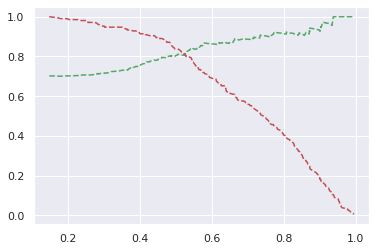

In [ ]:
y_test_prob = rf.predict_proba(x_test)
p, r, threshold = precision_recall_curve(y_test, y_test_prob[:,1])
plt.plot(threshold, p[:-1], "g--")
plt.plot(threshold, r[:-1], "r--")

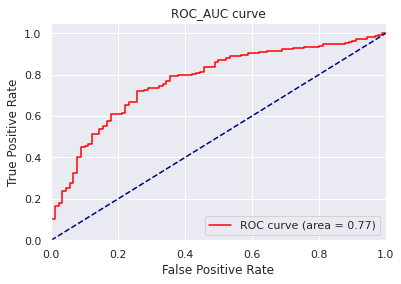

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_test_prob[:,1], pos_label=1)
plt.figure()
plt.plot(fpr, tpr, color='red',
         label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_AUC curve')
plt.legend(loc="lower right")
plt.show()

#### Observing the precision-recall curve, it appears that the ideal threshold for this data is around 0.2 to 0.4. Let's try that.

In [ ]:
thres_df = pd.DataFrame({'y_test':y_test, 'y_predicted_prob':y_test_prob[:,1]})
label_cols = ['y_label_45','y_label_48', 'y_label_50', 'y_label_55', 'y_label_60']
for enum, i in enumerate([0.45,0.48, 0.50, 0.55,0.60]):
    thres_df[label_cols[enum]] = thres_df['y_predicted_prob'].map(lambda x : 1 if (x > i) else 0)
thres_df.head()

y_test  y_predicted_prob  y_label_45  ...  y_label_50  y_label_55  y_label_60
534       1          0.828766           1  ...           1           1           1
248       1          0.666317           1  ...           1           1           1
317       1          0.509923           1  ...           1           0           0
13        0          0.531147           1  ...           1           0           0
659       1          0.626118           1  ...           1           1           1

[5 rows x 7 columns]

[[ 38  52]
 [ 22 188]]
0.9
0.42
0.8357142857142857


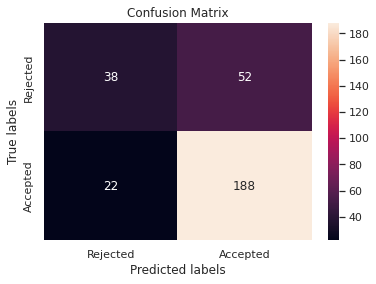

In [ ]:
confusion = confusion_matrix(thres_df.y_test, thres_df.y_label_45)
print(confusion)
precision = round((confusion[1,1]/(confusion[1,1]+confusion[0,1])),2)
recall = round((confusion[1,1]/(confusion[1,1]+confusion[1,0])),2)
specificity = round((confusion[0,0]/(confusion[0,0]+confusion[0,1])),2)
f1=2*((precision*recall)/(precision+recall))
print(recall)
print(specificity)
print(f1)
ax= plt.subplot()
sns.heatmap(confusion, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Rejected', 'Accepted']); ax.yaxis.set_ticklabels(['Rejected', 'Accepted']);

In [ ]:
confusion = confusion_matrix(thres_df.y_test, thres_df.y_label_50)
print(confusion)
precision = round((confusion[1,1]/(confusion[1,1]+confusion[0,1])),2)
recall = round((confusion[1,1]/(confusion[1,1]+confusion[1,0])),2)
specificity = round((confusion[0,0]/(confusion[0,0]+confusion[0,1])),2)
f1=2*((precision*recall)/(precision+recall))
print(recall)
print(specificity)
print(f1)

[[ 48  42]
 [ 34 176]]
0.84
0.53
0.8247272727272728


In [ ]:
confusion = confusion_matrix(thres_df.y_test, thres_df.y_label_55)
print(confusion)
precision = round((confusion[1,1]/(confusion[1,1]+confusion[0,1])),2)
recall = round((confusion[1,1]/(confusion[1,1]+confusion[1,0])),2)
specificity = round((confusion[0,0]/(confusion[0,0]+confusion[0,1])),2)
f1=2*((precision*recall)/(precision+recall))
print(recall)
print(specificity)
print(f1)

[[ 59  31]
 [ 49 161]]
0.77
0.66
0.8034782608695653


[[ 67  23]
 [ 65 145]]
0.69
0.74
0.7656774193548387


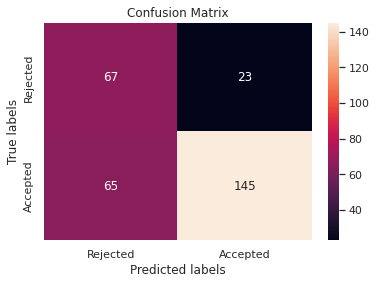

In [ ]:
confusion = confusion_matrix(thres_df.y_test, thres_df.y_label_60)
print(confusion)
precision = round((confusion[1,1]/(confusion[1,1]+confusion[0,1])),2)
recall = round((confusion[1,1]/(confusion[1,1]+confusion[1,0])),2)
specificity = round((confusion[0,0]/(confusion[0,0]+confusion[0,1])),2)
f1=2*((precision*recall)/(precision+recall))
print(recall)
print(specificity)
print(f1)
ax= plt.subplot()
sns.heatmap(confusion, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Rejected', 'Accepted']); ax.yaxis.set_ticklabels(['Rejected', 'Accepted']);

In [ ]:
!pip install pycaret

In [ ]:
from pycaret.utils import enable_colab
enable_colab()
from pycaret.classification import *

Colab mode enabled.


/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
experiment = setup(df_model, target='accepted')

Description             Value
0                               session_id              3350
1                                   Target          accepted
2                              Target Type            Binary
3                            Label Encoded        0: 0, 1: 1
4                            Original Data         (1000, 6)
5                           Missing Values             False
6                         Numeric Features                 4
7                     Categorical Features                 1
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set          (699, 8)
12                    Transformed Test Set          (301, 8)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU             False
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              37d0
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44             Remove Perfect Collinearity              True
45                              Clustering             False
46                    Clustering Iteration              None
47                     Polynomial Features             False
48                       Polynomial Degree              None
49                    Trignometry Features             False
50                    Polynomial Threshold              None
51                          Group Features             False
52                       Feature Selection             False
53                Feature Selection Method           classic
54            Features Selection Threshold              None
55                     Feature Interaction             False
56                           Feature Ratio             False
57                   Interaction Threshold              None
58                           Fix Imbalance             False
59                    Fix Imbalance Method             SMOTE

In [ ]:
best_model = compare_models(sort='F1')

Model  Accuracy     AUC  Recall   Prec.  \
ada                  Ada Boost Classifier    0.7382  0.7471  0.8714  0.7785   
catboost              CatBoost Classifier    0.7440  0.7678  0.8529  0.7935   
gbc          Gradient Boosting Classifier    0.7382  0.7521  0.8591  0.7851   
lda          Linear Discriminant Analysis    0.7124  0.7133  0.9090  0.7372   
nb                            Naive Bayes    0.7153  0.6963  0.8966  0.7445   
ridge                    Ridge Classifier    0.7039  0.0000  0.9276  0.7231   
lightgbm  Light Gradient Boosting Machine    0.7254  0.7432  0.8323  0.7842   
lr                    Logistic Regression    0.6910  0.6594  0.9317  0.7110   
xgboost         Extreme Gradient Boosting    0.7139  0.7309  0.8238  0.7767   
rf               Random Forest Classifier    0.7083  0.7359  0.8342  0.7649   
et                 Extra Trees Classifier    0.6953  0.7167  0.8177  0.7604   
knn                K Neighbors Classifier    0.6537  0.5571  0.8363  0.7117   
dt               Decision Tree Classifier    0.6653  0.6183  0.7412  0.7671   
qda       Quadratic Discriminant Analysis    0.6367  0.6656  0.7184  0.7493   
svm                   SVM - Linear Kernel    0.5290  0.0000  0.5509  0.5859   

              F1   Kappa     MCC  TT (Sec)  
ada       0.8216  0.3327  0.3424     0.110  
catboost  0.8212  0.3698  0.3758     1.318  
gbc       0.8194  0.3437  0.3518     0.109  
lda       0.8138  0.2099  0.2354     0.018  
nb        0.8129  0.2338  0.2566     0.015  
ridge     0.8122  0.1568  0.1929     0.014  
lightgbm  0.8069  0.3309  0.3348     0.094  
lr        0.8063  0.1031  0.1332     0.338  
xgboost   0.7986  0.3029  0.3083     0.916  
rf        0.7976  0.2764  0.2822     0.515  
et        0.7872  0.2505  0.2552     0.467  
knn       0.7685  0.0934  0.1021     0.118  
dt        0.7531  0.2322  0.2335     0.016  
qda       0.7206  0.1680  0.1775     0.017  
svm       0.5179  0.0276  0.0395     0.015

In [ ]:
#### Ada Boost Classifier

In [ ]:
ada = create_model('ada')
tuned_ada = tune_model(ada,optimize='F1')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.6857  0.7528  0.8542  0.7321  0.7885  0.1912  0.2000
1       0.8286  0.8911  0.9167  0.8462  0.8800  0.5817  0.5874
2       0.7429  0.7491  0.8750  0.7778  0.8235  0.3558  0.3643
3       0.6143  0.6501  0.7917  0.6909  0.7379  0.0207  0.0214
4       0.7143  0.7192  0.8750  0.7500  0.8077  0.2647  0.2770
5       0.7429  0.7969  0.8750  0.7778  0.8235  0.3558  0.3643
6       0.7429  0.7454  0.9388  0.7541  0.8364  0.2683  0.3073
7       0.8143  0.8513  0.8776  0.8600  0.8687  0.5517  0.5521
8       0.7714  0.7191  0.9388  0.7797  0.8519  0.3701  0.4026
9       0.7681  0.7619  0.8750  0.8077  0.8400  0.4214  0.4259
Mean    0.7425  0.7637  0.8818  0.7776  0.8258  0.3381  0.3502
SD      0.0587  0.0652  0.0410  0.0483  0.0390  0.1569  0.1561

In [ ]:
print(tuned_ada.base_estimator_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [ ]:
tuned_ada.get_params

<bound method BaseEstimator.get_params of AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=40, random_state=3350)>

In [ ]:

bagged_tuned_ada = ensemble_model(tuned_ada, method = 'Bagging')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.6429  0.6638  0.8542  0.6949  0.7664  0.0416  0.0459
1       0.8286  0.8835  0.9167  0.8462  0.8800  0.5817  0.5874
2       0.7857  0.7746  0.9167  0.8000  0.8544  0.4560  0.4714
3       0.6714  0.6752  0.8333  0.7273  0.7767  0.1658  0.1714
4       0.7000  0.7320  0.8750  0.7368  0.8000  0.2173  0.2306
5       0.7429  0.8116  0.8750  0.7778  0.8235  0.3558  0.3643
6       0.7286  0.7289  0.9184  0.7500  0.8257  0.2400  0.2673
7       0.8571  0.8630  0.9184  0.8824  0.9000  0.6503  0.6519
8       0.7714  0.7221  0.9592  0.7705  0.8545  0.3496  0.4005
9       0.7246  0.7272  0.8958  0.7544  0.8190  0.2606  0.2782
Mean    0.7453  0.7582  0.8963  0.7740  0.8300  0.3319  0.3469
SD      0.0636  0.0703  0.0352  0.0533  0.0407  0.1785  0.1776

In [ ]:
### Catboost

In [ ]:
cat = create_model('catboost')
tuned_cat = tune_model(cat,optimize='F1')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7571  0.7661  0.8958  0.7818  0.8350  0.3834  0.3964
1       0.7857  0.8835  0.9167  0.8000  0.8544  0.4560  0.4714
2       0.7714  0.7874  0.9375  0.7759  0.8491  0.3952  0.4269
3       0.6429  0.6179  0.8750  0.6885  0.7706  0.0135  0.0158
4       0.7000  0.7552  0.8958  0.7288  0.8037  0.1950  0.2150
5       0.7571  0.8049  0.9375  0.7627  0.8411  0.3483  0.3841
6       0.7286  0.7522  0.9184  0.7500  0.8257  0.2400  0.2673
7       0.8286  0.8503  0.9388  0.8364  0.8846  0.5556  0.5698
8       0.7571  0.6968  0.9388  0.7667  0.8440  0.3200  0.3563
9       0.6957  0.7490  0.9167  0.7213  0.8073  0.1297  0.1540
Mean    0.7424  0.7663  0.9171  0.7612  0.8316  0.3037  0.3257
SD      0.0499  0.0709  0.0211  0.0398  0.0300  0.1530  0.1554

In [ ]:

bagged_tuned_cat = ensemble_model(tuned_cat, method = 'Bagging')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7000  0.7557  0.8750  0.7368  0.8000  0.2173  0.2306
1       0.7857  0.8864  0.9792  0.7705  0.8624  0.4081  0.4754
2       0.7714  0.7841  0.9375  0.7759  0.8491  0.3952  0.4269
3       0.6429  0.6411  0.8750  0.6885  0.7706  0.0135  0.0158
4       0.7143  0.7614  0.9375  0.7258  0.8182  0.1991  0.2404
5       0.7429  0.7926  0.9375  0.7500  0.8333  0.3000  0.3392
6       0.7286  0.7434  0.9184  0.7500  0.8257  0.2400  0.2673
7       0.8286  0.8601  1.0000  0.8033  0.8909  0.5122  0.5867
8       0.7571  0.7104  0.9592  0.7581  0.8468  0.2975  0.3527
9       0.7246  0.7609  0.9583  0.7302  0.8288  0.1862  0.2430
Mean    0.7396  0.7696  0.9378  0.7489  0.8326  0.2769  0.3178
SD      0.0483  0.0660  0.0384  0.0299  0.0315  0.1327  0.1496

In [ ]:
bagged_tuned_cat.get_params

<bound method BaseEstimator.get_params of BaggingClassifier(base_estimator=<catboost.core.CatBoostClassifier object at 0x7f132fc0cf90>,
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10, n_jobs=None,
                  oob_score=False, random_state=3350, verbose=0,
                  warm_start=False)>

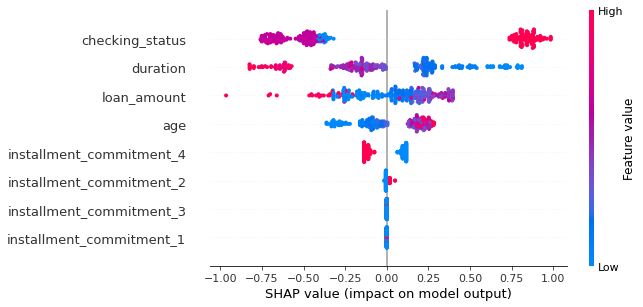

In [ ]:
interpret_model(tuned_cat)

### XGBoost

In [ ]:
xgboost = create_model('xgboost')
tuned_xgboost = tune_model(xgboost,optimize='F1')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7000  0.7708  1.0000  0.6957  0.8205  0.0613  0.1778
1       0.7857  0.8163  0.9792  0.7705  0.8624  0.4081  0.4754
2       0.7286  0.8239  0.9583  0.7302  0.8288  0.2276  0.2872
3       0.6571  0.6581  0.9167  0.6875  0.7857  0.0094  0.0126
4       0.7000  0.6951  0.9375  0.7143  0.8108  0.1463  0.1846
5       0.7429  0.7443  0.9583  0.7419  0.8364  0.2792  0.3371
6       0.7143  0.7250  1.0000  0.7101  0.8305  0.0654  0.1839
7       0.7571  0.7949  0.9796  0.7500  0.8496  0.2735  0.3563
8       0.7429  0.7580  1.0000  0.7313  0.8448  0.1892  0.3232
9       0.7391  0.7897  0.9583  0.7419  0.8364  0.2418  0.2994
Mean    0.7268  0.7576  0.9688  0.7273  0.8306  0.1902  0.2638
SD      0.0339  0.0505  0.0268  0.0243  0.0204  0.1154  0.1213

In [ ]:
tuned_xgboost.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=90, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=3350, reg_alpha=2,
              reg_lambda=4, scale_pos_weight=28.700000000000003, subsample=1,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0)>

In [ ]:
## More Experiment

In [ ]:
xgmodel = XGBClassifier()

In [ ]:
xgmodel.fit(x_train, y_train)

[10:51:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [ ]:
y_pred = xgmodel.predict(x_test)
print("Accuracy",accuracy_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("F1 score",f1_score(y_test, y_pred))
print("AUC",roc_auc_score(y_test, y_pred))

Accuracy 0.7633333333333333
Recall: 0.9
Precision: 0.7907949790794979
F1 score 0.8418708240534521
AUC 0.6722222222222222


In [ ]:
# Build GridSearchCV to find optimal hyperparameters
model = XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1)
params = {'max_depth':[3, 4, 5, 6, 7, 8, 9, 10, 11],
 'min_child_weight':[1, 2, 3, 4, 5, 6, 7],
 'n_estimators':[50, 100, 150, 250, 300],
 'eta':[.3, .2, .1, .05, .01, .005]}
n_folds = StratifiedKFold(n_splits = 10, random_state = 100)
gridmodel = GridSearchCV(estimator = model,
                         param_grid = params,
                         cv = n_folds,
                         scoring = 'roc_auc',
                         n_jobs = -1)

In [ ]:
# Build GridSearchCV to find optimal hyperparameters
model = XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1)
params = {'max_depth':[3, 4, 5, 6, 7, 8, 9, 10, 11],
 'min_child_weight':[1, 2, 3, 4, 5, 6, 7],
 'n_estimators':[50, 100, 150, 250, 300],
 'eta':[.3, .2, .1, .05, .01, .005]}
n_folds = StratifiedKFold(n_splits = 10, random_state = 100)
gridmodelf1 = GridSearchCV(estimator = model,
                         param_grid = params,
                         cv = n_folds,
                         scoring = 'f1',
                         n_jobs = -1)

In [ ]:
gridmodel.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=100, shuffle=False),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=1, objective='binary:log...
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=True,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'eta': [0.3, 0.2, 0.1, 0.05, 0.01, 0.005],
                         'max_depth': [3, 4, 

In [ ]:
gridmodelf1.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=100, shuffle=False),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=1, objective='binary:log...
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=True,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'eta': [0.3, 0.2, 0.1, 0.05, 0.01, 0.005],
                         'max_depth': [3, 4, 

In [ ]:
gridmodel.best_params_

{'eta': 0.3, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 50}

In [ ]:
gridmodelf1.best_params_

{'eta': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50}

In [ ]:
cv_results = pd.DataFrame(gridmodel.cv_results_)

In [ ]:
cv_results[cv_results['rank_test_score']==2]['params'].values

array([{'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 300}],
      dtype=object)

In [ ]:
cv_results

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0         0.041584      0.007260  ...        0.070442              279
1         0.062452      0.004736  ...        0.071343               64
2         0.085275      0.003563  ...        0.065082               61
3         0.134013      0.004562  ...        0.062356               41
4         0.158461      0.009782  ...        0.058881               25
..             ...           ...  ...             ...              ...
310       0.052490      0.001777  ...        0.070640              113
311       0.099132      0.004009  ...        0.064506               83
312       0.143414      0.004345  ...        0.064310               47
313       0.227802      0.005082  ...        0.067640              116
314       0.258284      0.027693  ...        0.069102              169

[315 rows x 21 columns]

In [ ]:
xgb_tunned = XGBClassifier(eta= 0.3, max_depth= 3, min_child_weight= 6, n_estimators= 50)

In [ ]:
xgb_tunned = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=6, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_tunned.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=6, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = xgb_tunned.predict(x_test)
print("Accuracy",accuracy_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("F1 score",f1_score(y_test, y_pred))
print("AUC",roc_auc_score(y_test, y_pred))

Accuracy 0.7433333333333333
Recall: 0.9
Precision: 0.7714285714285715
F1 score 0.8307692307692307
AUC 0.6388888888888888


In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [ ]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf, verbose=3, random_state=1001 )

In [ ]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [ ]:
random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=5, scoring='roc_auc', n_jobs=-1, cv=n_folds, verbose=3, random_state=1001 )

In [ ]:
x_train.values

array([[4.800e+01, 2.700e+01, 5.190e+03, 4.000e+00, 3.940e-01],
       [5.000e+01, 2.100e+01, 2.241e+03, 4.000e+00, 3.940e-01],
       [3.200e+01, 2.400e+01, 2.978e+03, 4.000e+00, 3.940e-01],
       ...,
       [2.800e+01, 2.400e+01, 2.284e+03, 4.000e+00, 3.940e-01],
       [2.600e+01, 1.500e+01, 2.687e+03, 2.000e+00, 6.300e-02],
       [3.500e+01, 1.200e+01, 2.141e+03, 3.000e+00, 3.940e-01]])

In [ ]:
model = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1,max_depth=3,min_child_weight=1)

In [ ]:
model.fit(x_train, y_train.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, verbosity=1)

In [ ]:
dt = create_model('dt')

In [ ]:
rf = create_model('rf')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7000  0.6241  0.8333  0.7547  0.7921  0.2583  0.2624
1       0.6857  0.6638  0.8125  0.7500  0.7800  0.2331  0.2354
2       0.6286  0.6212  0.7500  0.7200  0.7347  0.1165  0.1168
3       0.7286  0.7656  0.8750  0.7636  0.8155  0.3109  0.3214
4       0.7571  0.8456  0.8542  0.8039  0.8283  0.4149  0.4172
5       0.6857  0.6681  0.7917  0.7600  0.7755  0.2524  0.2530
6       0.7857  0.7609  0.8958  0.8113  0.8515  0.4702  0.4777
7       0.7571  0.7666  0.9167  0.7719  0.8381  0.3663  0.3889
8       0.6857  0.6832  0.8542  0.7321  0.7885  0.1912  0.2000
9       0.7536  0.7178  0.8958  0.7818  0.8350  0.3580  0.3712
Mean    0.7168  0.7117  0.8479  0.7649  0.8039  0.2972  0.3044
SD      0.0452  0.0687  0.0493  0.0273  0.0342  0.1020  0.1048

In [ ]:
tuned_rf = tune_model(rf)

In [ ]:
tuned_rf = tune_model(rf,optimize='F1')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.6857  0.6624  1.0000  0.6857  0.8136  0.0000  0.0000
1       0.6857  0.5909  1.0000  0.6857  0.8136  0.0000  0.0000
2       0.6571  0.6662  0.9583  0.6765  0.7931 -0.0553 -0.1161
3       0.6857  0.7618  1.0000  0.6857  0.8136  0.0000  0.0000
4       0.6857  0.8196  1.0000  0.6857  0.8136  0.0000  0.0000
5       0.6857  0.7737  1.0000  0.6857  0.8136  0.0000  0.0000
6       0.6857  0.7022  0.9792  0.6912  0.8103  0.0327  0.0686
7       0.6857  0.7623  1.0000  0.6857  0.8136  0.0000  0.0000
8       0.7143  0.7595  1.0000  0.7059  0.8276  0.1206  0.2533
9       0.7246  0.7321  1.0000  0.7164  0.8348  0.1277  0.2612
Mean    0.6896  0.7231  0.9938  0.6904  0.8147  0.0226  0.0467
SD      0.0173  0.0641  0.0133  0.0111  0.0103  0.0547  0.1135

In [ ]:
tuned_rf.base_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
tuned_rf.n_estimators

280

In [ ]:
bagged_tuned_rf = ensemble_model(tuned_rf, method = 'Bagging')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.6714  0.6648  0.9583  0.6866  0.8000  0.0049  0.0087
1       0.6857  0.6165  1.0000  0.6857  0.8136  0.0000  0.0000
2       0.6571  0.6510  0.9583  0.6765  0.7931 -0.0553 -0.1161
3       0.6857  0.7765  1.0000  0.6857  0.8136  0.0000  0.0000
4       0.7000  0.8466  1.0000  0.6957  0.8205  0.0613  0.1778
5       0.7000  0.7855  1.0000  0.6957  0.8205  0.0613  0.1778
6       0.6714  0.7159  0.9792  0.6812  0.8034 -0.0281 -0.0815
7       0.7143  0.7699  1.0000  0.7059  0.8276  0.1206  0.2533
8       0.7143  0.7746  1.0000  0.7059  0.8276  0.1206  0.2533
9       0.6957  0.7321  0.9792  0.7015  0.8174  0.0359  0.0735
Mean    0.6896  0.7333  0.9875  0.6920  0.8137  0.0321  0.0747
SD      0.0179  0.0677  0.0167  0.0098  0.0110  0.0561  0.1270

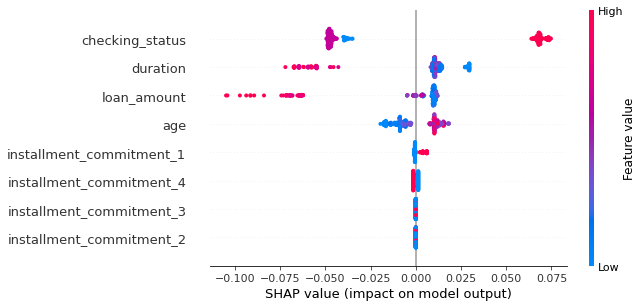

In [ ]:
interpret_model(tuned_rf)

In [ ]:
xg = create_model('xgboost')

In [ ]:
feature_imp_r = pd.DataFrame({'Columns':x_train.columns, 'Importance':tuned_rf.feature_importances_})
feature_imp_r.sort_values(by = 'Importance', ascending = False, inplace = True)
feature_imp_r.head()

In [ ]:
lightgbm = create_model('lightgbm')

In [ ]:
gbc = create_model('gbc')

In [ ]:
tuned_lightgbm = tune_model(lightgbm,optimize='F1')

In [ ]:
tuned_gbc = tune_model(gbc,optimize='F1')

In [ ]:
bagged_gbc = ensemble_model(tuned_gbc, method = 'Bagging')

In [ ]:
Boosting_gbc = ensemble_model(tuned_gbc, method = 'Boosting')